In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.optimize import fsolve

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


## DATA

In [4]:
title = "LQ down 1000 GeV"

In [5]:
##############
# input data #
##############

# b1,b2 -> (pT, eta, phi) from the leading and second b-tagged jets
# tau -> (pT, eta, phi) from the tau
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, num_jets, num_btag)  HT: sum PT of all the jets, number of jets (b-tag or not), number of b-tagged jets


################
# New Physics: #
################

datFolderNP = 'DATA/signal/dats-LQdown-1000GeV/'
k_LQdown = 1.8247261601649074
crossfidNP = 0.176696976*k_LQdown

b1_NP = np.loadtxt(datFolderNP + 'b1.dat', delimiter=' ')
b2_NP = np.loadtxt(datFolderNP + 'b2.dat', delimiter=' ')
tau_NP = np.loadtxt(datFolderNP + 'tau.dat', delimiter=' ')
MET_NP = np.loadtxt(datFolderNP + 'MET.dat', delimiter=' ')
hadinfo_NP = np.loadtxt(datFolderNP + 'hadinfo.dat', delimiter=' ')

print('# eventos LQ: ', len(b1_NP))



###############
# Background: #
###############

# tt and fakett

datFolderSM_tt = 'DATA/background/dats-tt/'

k_fakett = 1.1053030485310749
crossfid_fakett = 0.19136
k_tt = 1.2593273872014419
crossfid_tt = (5.1373984*k_tt) + (crossfid_fakett * k_fakett)

b1_SM_tt = np.loadtxt(datFolderSM_tt + 'b1.dat', delimiter=' ')
b2_SM_tt = np.loadtxt(datFolderSM_tt + 'b2.dat', delimiter=' ')
tau_SM_tt = np.loadtxt(datFolderSM_tt + 'tau.dat', delimiter=' ')
MET_SM_tt = np.loadtxt(datFolderSM_tt + 'MET.dat', delimiter=' ')
hadinfo_SM_tt = np.loadtxt(datFolderSM_tt + 'hadinfo.dat', delimiter=' ')

print('# eventos tt: ', len(b1_SM_tt))


# singlet part 1

datFolderSM_singletP1 = 'DATA/background/dats-singletP1/'
k_singletTOTAL = 3.440676833094312 # it is the total k_singlet
crossfid_singletP1 = 0.39648*k_singletTOTAL

b1_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'b1.dat', delimiter=' ')
b2_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'b2.dat', delimiter=' ')
tau_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'tau.dat', delimiter=' ')
MET_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'MET.dat', delimiter=' ')
hadinfo_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'hadinfo.dat', delimiter=' ')

print('# eventos singlet part 1: ', len(b1_SM_singletP1))


# singlet part 2

datFolderSM_singletP2 = 'DATA/background/dats-singlet-comp/'
k_singletTOTAL = 3.440676833094312 # it is the total k_singlet
crossfid_singletP2 = 0.283008*k_singletTOTAL

b1_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'b1.dat', delimiter=' ')
b2_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'b2.dat', delimiter=' ')
tau_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'tau.dat', delimiter=' ')
MET_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'MET.dat', delimiter=' ')
hadinfo_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'hadinfo.dat', delimiter=' ')

print('# eventos singlet part 2: ', len(b1_SM_singletP2))


# Wbbjets

datFolderSM_Wbbjets = 'DATA/background/dats-Wbbjets/'
k_wjets = 0.9781509289273502
crossfid_Wbbjets = 0.9988452079186325*k_wjets

b1_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'b1.dat', delimiter=' ')
b2_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'b2.dat', delimiter=' ')
tau_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'tau.dat', delimiter=' ')
MET_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'MET.dat', delimiter=' ')
hadinfo_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'hadinfo.dat', delimiter=' ')

print('# eventos Wbbjets: ', len(b1_SM_Wbbjets))


# ttW (part of ttV)

datFolderSM_ttW = 'DATA/background/dats-ttW/'
k_ttV = 3.056401327463198 # it is the total ttV
crossfid_ttW = 0.0231785208*k_ttV

b1_SM_ttW = np.loadtxt(datFolderSM_ttW + 'b1.dat', delimiter=' ')
b2_SM_ttW = np.loadtxt(datFolderSM_ttW + 'b2.dat', delimiter=' ')
tau_SM_ttW = np.loadtxt(datFolderSM_ttW + 'tau.dat', delimiter=' ')
MET_SM_ttW = np.loadtxt(datFolderSM_ttW + 'MET.dat', delimiter=' ')
hadinfo_SM_ttW = np.loadtxt(datFolderSM_ttW + 'hadinfo.dat', delimiter=' ')

print('# eventos ttW: ', len(b1_SM_ttW))


# ttZ

datFolderSM_ttZ = 'DATA/background/dats-ttZ/'
k_ttV = 3.056401327463198 # it is the total ttV
crossfid_ttZ = 0.050087088*k_ttV

b1_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'b1.dat', delimiter=' ')
b2_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'b2.dat', delimiter=' ')
tau_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'tau.dat', delimiter=' ')
MET_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'MET.dat', delimiter=' ')
hadinfo_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'hadinfo.dat', delimiter=' ')

print('# eventos ttZ: ', len(b1_SM_ttZ))


# ttH

datFolderSM_ttH = 'DATA/background/dats-ttH/'
k_ttH = 2.2127445612386474
crossfid_ttH = 0.025004896*k_ttH

b1_SM_ttH = np.loadtxt(datFolderSM_ttH + 'b1.dat', delimiter=' ')
b2_SM_ttH = np.loadtxt(datFolderSM_ttH + 'b2.dat', delimiter=' ')
tau_SM_ttH = np.loadtxt(datFolderSM_ttH + 'tau.dat', delimiter=' ')
MET_SM_ttH = np.loadtxt(datFolderSM_ttH + 'MET.dat', delimiter=' ')
hadinfo_SM_ttH = np.loadtxt(datFolderSM_ttH + 'hadinfo.dat', delimiter=' ')

print('# eventos ttH: ', len(b1_SM_ttH))

# eventos LQ:  499346
# eventos tt:  826022
# eventos singlet part 1:  179677
# eventos singlet part 2:  94219
# eventos Wbbjets:  162448
# eventos ttW:  141919
# eventos ttZ:  16178
# eventos ttH:  12068


In [6]:
# Number of data points (per-class) for the ML classifier
num_data_NP = int(len(b1_NP)-1)
print(' SIGNAL ')
print('# S chosen: ', num_data_NP)



totalcrossSM = crossfid_tt + crossfid_singletP1+crossfid_singletP2 + crossfid_Wbbjets + crossfid_ttW+crossfid_ttZ + crossfid_ttH

num_data_SM_singletP1 = round( num_data_NP * (crossfid_singletP1/totalcrossSM) )
num_data_SM_singletP2 = round( num_data_NP * (crossfid_singletP2/totalcrossSM) )
num_data_SM_Wbbjets = round( num_data_NP * (crossfid_Wbbjets/totalcrossSM) )
num_data_SM_ttW = round( num_data_NP * (crossfid_ttW/totalcrossSM) )
num_data_SM_ttZ = round( num_data_NP * (crossfid_ttZ/totalcrossSM) )
num_data_SM_ttH = round( num_data_NP * (crossfid_ttH/totalcrossSM) )

num_data_SM_tt = num_data_NP - (num_data_SM_singletP1+num_data_SM_singletP2 + num_data_SM_Wbbjets + num_data_SM_ttW+num_data_SM_ttZ + num_data_SM_ttH)

num_data_SM = num_data_SM_tt + num_data_SM_singletP1+num_data_SM_singletP2 + num_data_SM_Wbbjets + num_data_SM_ttW+num_data_SM_ttZ +  num_data_SM_ttH


print('\n BACKGROUND ')
print('# tt chosen: ', num_data_SM_tt)
print('# singletP1 chosen: ', num_data_SM_singletP1)
print('# singletP2 chosen: ', num_data_SM_singletP2)
print('# Wbbjets chosen: ', num_data_SM_Wbbjets)
print('# ttW chosen: ', num_data_SM_ttW)
print('# ttZ chosen: ', num_data_SM_ttZ)
print('# ttH chosen: ', num_data_SM_ttH)

print('\n# total B eventos chosen: ', num_data_SM)



# CHECK IF THE NUMBER OF EVENTS ARE CORRECT
if num_data_SM == num_data_NP and num_data_NP < len(b1_NP) and num_data_SM_tt < len(b1_SM_tt) and num_data_SM_singletP1 < len(b1_SM_singletP1) and num_data_SM_singletP2 < len(b1_SM_singletP2) and num_data_SM_Wbbjets < len(b1_SM_Wbbjets) and num_data_SM_ttW < len(b1_SM_ttW) and num_data_SM_ttZ < len(b1_SM_ttZ) and num_data_SM_ttH < len(b1_SM_ttH):
    print( '\nEverything OK, continue')
else:
    print( '\nThe number of events of each channel not enought, check if you need to generate more')

 SIGNAL 
# S chosen:  499345

 BACKGROUND 
# tt chosen:  324681
# singletP1 chosen:  66293
# singletP2 chosen:  47320
# Wbbjets chosen:  47480
# ttW chosen:  3443
# ttZ chosen:  7439
# ttH chosen:  2689

# total B eventos chosen:  499345

Everything OK, continue


In [7]:
# KEEP ONLY THE NUMBER OF SIGNAL EVENTS THAT WE WILL USE
b1_NP = b1_NP[:num_data_NP]
b2_NP = b2_NP[:num_data_NP]
tau_NP = tau_NP[:num_data_NP]
MET_NP = MET_NP[:num_data_NP]
hadinfo_NP = hadinfo_NP[:num_data_NP]


# CONCATENATE YOUR SELECTED BACKGROUNDS (as many as you want, with the correct proportion)

b1_SM = np.concatenate((b1_SM_tt[:num_data_SM_tt],b1_SM_singletP1[:num_data_SM_singletP1],b1_SM_singletP2[:num_data_SM_singletP2],b1_SM_Wbbjets[:num_data_SM_Wbbjets],b1_SM_ttW[:num_data_SM_ttW],b1_SM_ttZ[:num_data_SM_ttZ],b1_SM_ttH[:num_data_SM_ttH]))
b2_SM = np.concatenate((b2_SM_tt[:num_data_SM_tt],b2_SM_singletP1[:num_data_SM_singletP1],b2_SM_singletP2[:num_data_SM_singletP2],b2_SM_Wbbjets[:num_data_SM_Wbbjets],b2_SM_ttW[:num_data_SM_ttW],b2_SM_ttZ[:num_data_SM_ttZ],b2_SM_ttH[:num_data_SM_ttH]))
tau_SM = np.concatenate((tau_SM_tt[:num_data_SM_tt],tau_SM_singletP1[:num_data_SM_singletP1],tau_SM_singletP2[:num_data_SM_singletP2],tau_SM_Wbbjets[:num_data_SM_Wbbjets],tau_SM_ttW[:num_data_SM_ttW],tau_SM_ttZ[:num_data_SM_ttZ],tau_SM_ttH[:num_data_SM_ttH]))
MET_SM = np.concatenate((MET_SM_tt[:num_data_SM_tt],MET_SM_singletP1[:num_data_SM_singletP1],MET_SM_singletP2[:num_data_SM_singletP2],MET_SM_Wbbjets[:num_data_SM_Wbbjets],MET_SM_ttW[:num_data_SM_ttW],MET_SM_ttZ[:num_data_SM_ttZ],MET_SM_ttH[:num_data_SM_ttH]))
hadinfo_SM = np.concatenate((hadinfo_SM_tt[:num_data_SM_tt],hadinfo_SM_singletP1[:num_data_SM_singletP1],hadinfo_SM_singletP2[:num_data_SM_singletP2],hadinfo_SM_Wbbjets[:num_data_SM_Wbbjets],hadinfo_SM_ttW[:num_data_SM_ttW],hadinfo_SM_ttZ[:num_data_SM_ttZ],hadinfo_SM_ttH[:num_data_SM_ttH]))

del b1_SM_tt
del b2_SM_tt
del tau_SM_tt
del MET_SM_tt
del hadinfo_SM_tt

del b1_SM_singletP1
del b2_SM_singletP1
del tau_SM_singletP1
del MET_SM_singletP1
del hadinfo_SM_singletP1

del b1_SM_singletP2
del b2_SM_singletP2
del tau_SM_singletP2
del MET_SM_singletP2
del hadinfo_SM_singletP2

del b1_SM_Wbbjets
del b2_SM_Wbbjets
del tau_SM_Wbbjets
del MET_SM_Wbbjets
del hadinfo_SM_Wbbjets

del b1_SM_ttW
del b2_SM_ttW
del tau_SM_ttW
del MET_SM_ttW
del hadinfo_SM_ttW

del b1_SM_ttZ
del b2_SM_ttZ
del tau_SM_ttZ
del MET_SM_ttZ
del hadinfo_SM_ttZ

del b1_SM_ttH
del b2_SM_ttH
del tau_SM_ttH
del MET_SM_ttH
del hadinfo_SM_ttH

In [8]:
print('# Background events: ', len(b1_SM))
print('# Signal events: ', len(b1_NP))

# Background events:  499345
# Signal events:  499345


### pdfs

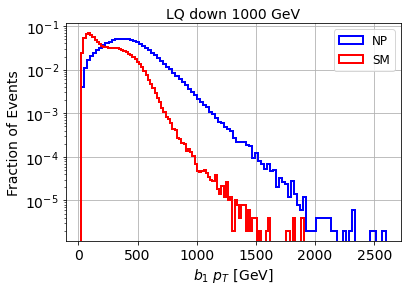

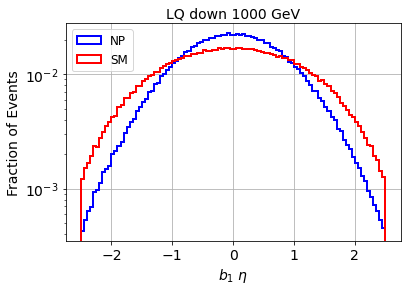

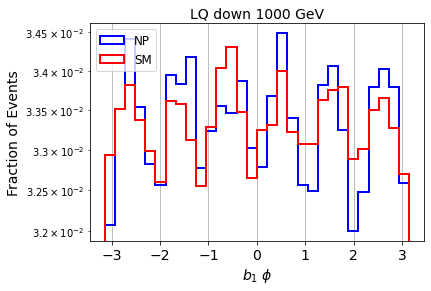

In [9]:
weights = np.ones_like(b1_NP[:,0])/float(len(b1_NP[:,0]))
plt.hist(b1_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b1_SM[:,0])/float(len(b1_SM[:,0]))
plt.hist(b1_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_1$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(b1_NP[:,1])/float(len(b1_NP[:,1]))
plt.hist(b1_NP[:,1], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b1_SM[:,1])/float(len(b1_SM[:,1]))
plt.hist(b1_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_1$ $\eta$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(b1_NP[:,2])/float(len(b1_NP[:,2]))
plt.hist(b1_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b1_SM[:,2])/float(len(b1_SM[:,2]))
plt.hist(b1_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_1$ $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

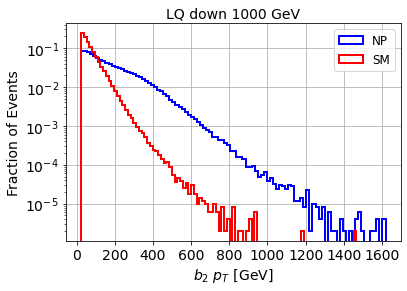

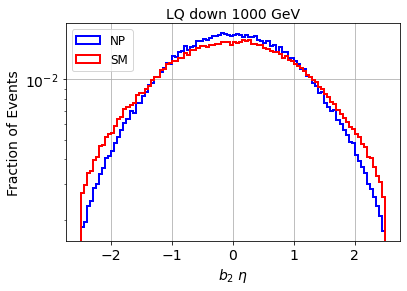

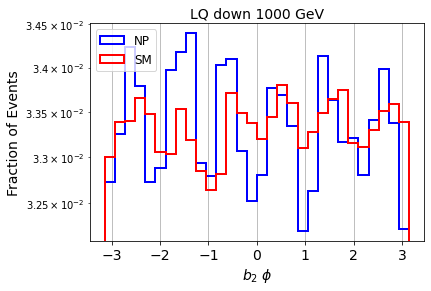

In [10]:
weights = np.ones_like(b2_NP[:,0])/float(len(b2_NP[:,0]))
plt.hist(b2_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b2_SM[:,0])/float(len(b2_SM[:,0]))
plt.hist(b2_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_2$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(b2_NP[:,1])/float(len(b2_NP[:,1]))
plt.hist(b2_NP[:,1], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b2_SM[:,1])/float(len(b2_SM[:,1]))
plt.hist(b2_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_2$ $\eta$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(b2_NP[:,2])/float(len(b2_NP[:,2]))
plt.hist(b2_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b2_SM[:,2])/float(len(b2_SM[:,2]))
plt.hist(b2_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_2$ $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

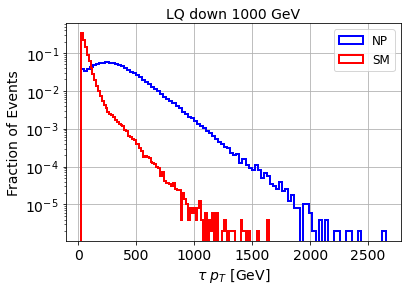

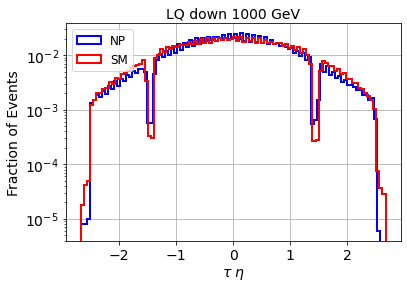

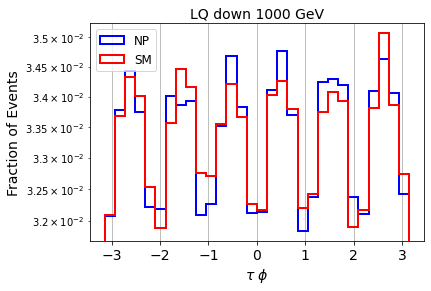

In [11]:
weights = np.ones_like(tau_NP[:,0])/float(len(tau_NP[:,0]))
plt.hist(tau_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(tau_SM[:,0])/float(len(tau_SM[:,0]))
plt.hist(tau_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel(r"$\tau$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(tau_NP[:,1])/float(len(tau_NP[:,1]))
plt.hist(tau_NP[:,1], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(tau_SM[:,1])/float(len(tau_SM[:,1]))
plt.hist(tau_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel(r"$\tau$ $\eta$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(tau_NP[:,2])/float(len(tau_NP[:,2]))
plt.hist(tau_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(tau_SM[:,2])/float(len(tau_SM[:,2]))
plt.hist(tau_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel(r"$\tau$ $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

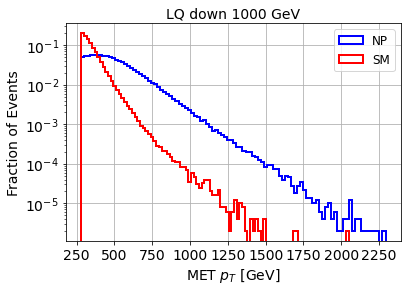

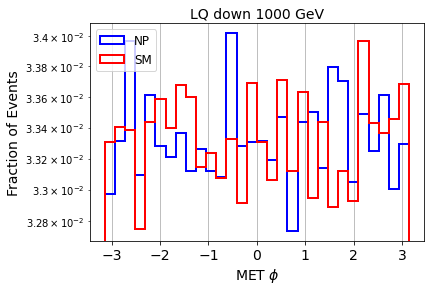

In [12]:
weights = np.ones_like(MET_NP[:,0])/float(len(MET_NP[:,0]))
plt.hist(MET_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(MET_SM[:,0])/float(len(MET_SM[:,0]))
plt.hist(MET_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("MET $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()


weights = np.ones_like(MET_NP[:,2])/float(len(MET_NP[:,2]))
plt.hist(MET_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(MET_SM[:,2])/float(len(MET_SM[:,2]))
plt.hist(MET_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("MET $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

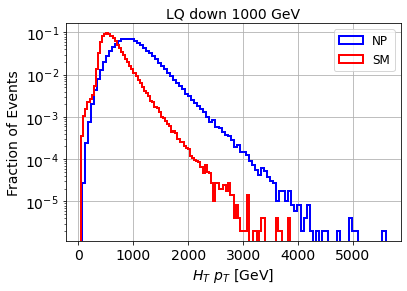

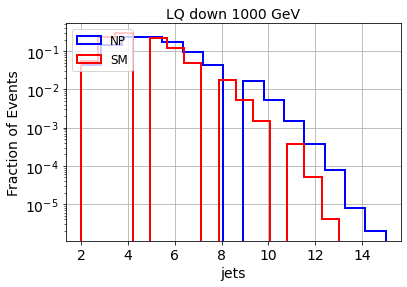

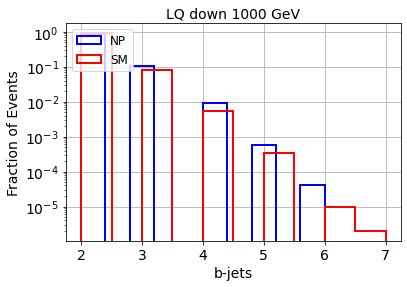

In [13]:
weights = np.ones_like(hadinfo_NP[:,0])/float(len(hadinfo_NP[:,0]))
plt.hist(hadinfo_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(hadinfo_SM[:,0])/float(len(hadinfo_SM[:,0]))
plt.hist(hadinfo_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$H_T$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(hadinfo_NP[:,1])/float(len(hadinfo_NP[:,1]))
plt.hist(hadinfo_NP[:,1], weights=weights, bins=15, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(hadinfo_SM[:,1])/float(len(hadinfo_SM[:,1]))
plt.hist(hadinfo_SM[:,1], weights=weights, bins=15, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("jets",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(hadinfo_NP[:,2])/float(len(hadinfo_NP[:,2]))
plt.hist(hadinfo_NP[:,2], weights=weights, bins=10, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(hadinfo_SM[:,2])/float(len(hadinfo_SM[:,2]))
plt.hist(hadinfo_SM[:,2], weights=weights, bins=10, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("b-jets",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

### Train-test-val Dataset

In [14]:
# to normalize
scaler = preprocessing.MinMaxScaler()

# DATA WITH UNCERTAINTIES
err_pt_tau_SM = 0.1
err_pt_tau_NP = 0.

tau_SM_pt_upB = [i*(1. + err_pt_tau_SM) for i in tau_SM[:,0]]
tau_NP_pt_upB = [i*(1. + err_pt_tau_NP) for i in tau_NP[:,0]]

tau_SM_pt_downB = [i*(1. - err_pt_tau_SM) for i in tau_SM[:,0]]
tau_NP_pt_downB = [i*(1. - err_pt_tau_NP) for i in tau_NP[:,0]]



df = pd.DataFrame()

df['b1-pt']= np.concatenate([b1_SM[:,0],b1_NP[:,0]])
df['b1-eta']= np.concatenate([b1_SM[:,1],b1_NP[:,1]])
df['b1-phi']= np.concatenate([b1_SM[:,2],b1_NP[:,2]])
# remove the used data
del b1_SM
del b1_NP

df['b2-pt']= np.concatenate([b2_SM[:,0],b2_NP[:,0]])
df['b2-eta']= np.concatenate([b2_SM[:,1],b2_NP[:,1]])
df['b2-phi']= np.concatenate([b2_SM[:,2],b2_NP[:,2]])
# remove the used dat
del b2_SM
del b2_NP

df['tau-pt']= np.concatenate([tau_SM[:,0],tau_NP[:,0]])
df['tau-eta']= np.concatenate([tau_SM[:,1],tau_NP[:,1]])
df['tau-phi']= np.concatenate([tau_SM[:,2],tau_NP[:,2]])
# remove the used data
del tau_SM
del tau_NP

df['MET-pt']= np.concatenate([MET_SM[:,0],MET_NP[:,0]])
df['MET-phi']= np.concatenate([MET_SM[:,2],MET_NP[:,2]])
# remove the used data
del MET_SM
del MET_NP

df['HT-pt']= np.concatenate([hadinfo_SM[:,0],hadinfo_NP[:,0]])
df['num-jets']= np.concatenate([hadinfo_SM[:,1],hadinfo_NP[:,1]])
df['num-bjets']= np.concatenate([hadinfo_SM[:,2],hadinfo_NP[:,2]])
# remove the used data
del hadinfo_SM
del hadinfo_NP

df['Y'] = np.concatenate([np.zeros(num_data_SM),np.ones(num_data_NP)])



#df_upB = pd.DataFrame()
df_upB = df.copy()
df_upB['tau-pt'] = np.concatenate([tau_SM_pt_upB,tau_NP_pt_upB])
del tau_SM_pt_upB
del tau_NP_pt_upB

df_downB = df.copy()
df_downB['tau-pt'] = np.concatenate([tau_SM_pt_downB,tau_NP_pt_downB])
del tau_SM_pt_downB
del tau_NP_pt_downB


# NORMALIZE
df = scaler.fit_transform(df)
df = pd.DataFrame(df,columns=['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets','Y'])


# print df to see the data
print(df)


# X and Y for the classifier
X_mon = df[['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets']].values
y_mon = df[['Y']].values


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)


X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)


print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

           b1-pt    b1-eta    b1-phi     b2-pt    b2-eta    b2-phi    tau-pt  \
0       0.009558  0.639656  0.978199  0.003389  0.475990  0.432368  0.005985   
1       0.021332  0.184874  0.496181  0.027986  0.532013  0.058243  0.002001   
2       0.038420  0.628651  0.564290  0.013244  0.573629  0.929822  0.011064   
3       0.091195  0.276110  0.337842  0.080217  0.332533  0.454806  0.026035   
4       0.044950  0.747299  0.141948  0.013607  0.855342  0.447804  0.006209   
...          ...       ...       ...       ...       ...       ...       ...   
998685  0.302835  0.407363  0.672024  0.101392  0.116447  0.049013  0.159487   
998686  0.188792  0.413966  0.223902  0.035009  0.870348  0.265595  0.052812   
998687  0.102157  0.430572  0.592934  0.008395  0.279512  0.373488  0.022455   
998688  0.104298  0.226291  0.915659  0.057982  0.264706  0.088479  0.097137   
998689  0.256311  0.672469  0.711012  0.174147  0.755902  0.164227  0.045420   

         tau-eta   tau-phi    MET-pt   

In [15]:
# DATA WITH UNCERTAINTIES +1sigma

# NORMALIZE
df_upB = scaler.fit_transform(df_upB)
df_upB = pd.DataFrame(df_upB,columns=['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets','Y'])


# X and Y for the classifier
X_monupB = df_upB[['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets']].values
y_monupB = df_upB[['Y']].values

del df_upB

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_monupB_aux, X_monupB_test, y_monupB_aux, y_monupB_test = train_test_split(X_monupB,
                                                                y_monupB,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_monupB,
                                                                shuffle=True)


X_monupB_train, X_monupB_val, y_monupB_train, y_monupB_val = train_test_split(X_monupB_aux,
                                                                  y_monupB_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_monupB_aux,
                                                                  shuffle=True)


print('')
print('X_monupB_train : ', X_monupB_train.shape)
print('y_monupB_train : ', y_monupB_train.shape)
print('X_monupB_val : ', X_monupB_val.shape)
print('y_monupB_val : ', y_monupB_val.shape)
print('X_monupB_test : ', X_monupB_test.shape)
print('y_monupB_test : ', y_monupB_test.shape)
print('')


X_monupB_train :  (499344, 14)
y_monupB_train :  (499344, 1)
X_monupB_val :  (166449, 14)
y_monupB_val :  (166449, 1)
X_monupB_test :  (332897, 14)
y_monupB_test :  (332897, 1)



In [16]:
# DATA WITH UNCERTAINTIES -1sigma

# NORMALIZE
df_downB = scaler.fit_transform(df_downB)
df_downB = pd.DataFrame(df_downB,columns=['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets','Y'])


# X and Y for the classifier
X_mondownB = df_downB[['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets']].values
y_mondownB = df_downB[['Y']].values

del df_downB

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mondownB_aux, X_mondownB_test, y_mondownB_aux, y_mondownB_test = train_test_split(X_mondownB,
                                                                y_mondownB,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mondownB,
                                                                shuffle=True)


X_mondownB_train, X_mondownB_val, y_mondownB_train, y_mondownB_val = train_test_split(X_mondownB_aux,
                                                                  y_mondownB_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mondownB_aux,
                                                                  shuffle=True)


print('')
print('X_mondownB_train : ', X_mondownB_train.shape)
print('y_mondownB_train : ', y_mondownB_train.shape)
print('X_mondownB_val : ', X_mondownB_val.shape)
print('y_mondownB_val : ', y_mondownB_val.shape)
print('X_mondownB_test : ', X_mondownB_test.shape)
print('y_mondownB_test : ', y_mondownB_test.shape)
print('')


X_mondownB_train :  (499344, 14)
y_mondownB_train :  (499344, 1)
X_mondownB_val :  (166449, 14)
y_mondownB_val :  (166449, 1)
X_mondownB_test :  (332897, 14)
y_mondownB_test :  (332897, 1)



### XGBoost (per-event)

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62131	validation_1-logloss:0.62148
[1]	validation_0-logloss:0.56244	validation_1-logloss:0.56267
[2]	validation_0-logloss:0.51312	validation_1-logloss:0.51346
[3]	validation_0-logloss:0.47169	validation_1-logloss:0.47212
[4]	validation_0-logloss:0.43627	validation_1-logloss:0.43680
[5]	validation_0-logloss:0.40560	validation_1-logloss:0.40628
[6]	validation_0-logloss:0.37916	validation_1-logloss:0.37992
[7]	validation_0-logloss:0.35603	validation_1-logloss:0.35690
[8]	validation_0-logloss:0.33586	validation_1-logloss:0.33684
[9]	validation_0-logloss:0.31823	validation_1-logloss:0.31931
[10]	validation_0-logloss:0.30246	validation_1-logloss:0.30360
[11]	validation_0-logloss:0.28876	validation_1-logloss:0.29000
[12]	validation_0-logloss:0.27648	validation_1-logloss:0.27779
[13]	validation_0-logloss:0.26574	validation_1-logloss:0.26716
[14]	validation_0-logloss:0.25609	validation_1-logloss:0.25756
[15]	validation_0-logloss:0.24758	validation_1-logloss:0.24909
[1

[130]	validation_0-logloss:0.14908	validation_1-logloss:0.15509
[131]	validation_0-logloss:0.14906	validation_1-logloss:0.15508
[132]	validation_0-logloss:0.14893	validation_1-logloss:0.15497
[133]	validation_0-logloss:0.14887	validation_1-logloss:0.15494
[134]	validation_0-logloss:0.14876	validation_1-logloss:0.15484
[135]	validation_0-logloss:0.14795	validation_1-logloss:0.15408
[136]	validation_0-logloss:0.14776	validation_1-logloss:0.15392
[137]	validation_0-logloss:0.14766	validation_1-logloss:0.15383
[138]	validation_0-logloss:0.14763	validation_1-logloss:0.15383
[139]	validation_0-logloss:0.14753	validation_1-logloss:0.15376
[140]	validation_0-logloss:0.14749	validation_1-logloss:0.15376
[141]	validation_0-logloss:0.14729	validation_1-logloss:0.15357
[142]	validation_0-logloss:0.14727	validation_1-logloss:0.15357
[143]	validation_0-logloss:0.14719	validation_1-logloss:0.15354
[144]	validation_0-logloss:0.14706	validation_1-logloss:0.15343
[145]	validation_0-logloss:0.14704	valid

[259]	validation_0-logloss:0.12697	validation_1-logloss:0.13619
[260]	validation_0-logloss:0.12684	validation_1-logloss:0.13609
[261]	validation_0-logloss:0.12681	validation_1-logloss:0.13609
[262]	validation_0-logloss:0.12668	validation_1-logloss:0.13599
[263]	validation_0-logloss:0.12663	validation_1-logloss:0.13597
[264]	validation_0-logloss:0.12627	validation_1-logloss:0.13562
[265]	validation_0-logloss:0.12625	validation_1-logloss:0.13562
[266]	validation_0-logloss:0.12610	validation_1-logloss:0.13550
[267]	validation_0-logloss:0.12557	validation_1-logloss:0.13501
[268]	validation_0-logloss:0.12551	validation_1-logloss:0.13500
[269]	validation_0-logloss:0.12543	validation_1-logloss:0.13494
[270]	validation_0-logloss:0.12537	validation_1-logloss:0.13493
[271]	validation_0-logloss:0.12530	validation_1-logloss:0.13490
[272]	validation_0-logloss:0.12527	validation_1-logloss:0.13489
[273]	validation_0-logloss:0.12523	validation_1-logloss:0.13489
[274]	validation_0-logloss:0.12485	valid

[388]	validation_0-logloss:0.11519	validation_1-logloss:0.12776
[389]	validation_0-logloss:0.11475	validation_1-logloss:0.12732
[390]	validation_0-logloss:0.11473	validation_1-logloss:0.12732
[391]	validation_0-logloss:0.11469	validation_1-logloss:0.12731
[392]	validation_0-logloss:0.11467	validation_1-logloss:0.12731
[393]	validation_0-logloss:0.11463	validation_1-logloss:0.12731
[394]	validation_0-logloss:0.11460	validation_1-logloss:0.12730
[395]	validation_0-logloss:0.11456	validation_1-logloss:0.12729
[396]	validation_0-logloss:0.11404	validation_1-logloss:0.12677
[397]	validation_0-logloss:0.11401	validation_1-logloss:0.12677
[398]	validation_0-logloss:0.11399	validation_1-logloss:0.12677
[399]	validation_0-logloss:0.11397	validation_1-logloss:0.12677
[400]	validation_0-logloss:0.11394	validation_1-logloss:0.12675
[401]	validation_0-logloss:0.11391	validation_1-logloss:0.12675
[402]	validation_0-logloss:0.11377	validation_1-logloss:0.12664
[403]	validation_0-logloss:0.11374	valid

[517]	validation_0-logloss:0.10771	validation_1-logloss:0.12290
[518]	validation_0-logloss:0.10769	validation_1-logloss:0.12290
[519]	validation_0-logloss:0.10759	validation_1-logloss:0.12281
[520]	validation_0-logloss:0.10758	validation_1-logloss:0.12281
[521]	validation_0-logloss:0.10757	validation_1-logloss:0.12281
[522]	validation_0-logloss:0.10755	validation_1-logloss:0.12281
[523]	validation_0-logloss:0.10751	validation_1-logloss:0.12280
[524]	validation_0-logloss:0.10731	validation_1-logloss:0.12261
[525]	validation_0-logloss:0.10729	validation_1-logloss:0.12261
[526]	validation_0-logloss:0.10727	validation_1-logloss:0.12262
[527]	validation_0-logloss:0.10725	validation_1-logloss:0.12261
[528]	validation_0-logloss:0.10722	validation_1-logloss:0.12262
[529]	validation_0-logloss:0.10720	validation_1-logloss:0.12262
[530]	validation_0-logloss:0.10717	validation_1-logloss:0.12262
[531]	validation_0-logloss:0.10715	validation_1-logloss:0.12262
[532]	validation_0-logloss:0.10713	valid

[646]	validation_0-logloss:0.10227	validation_1-logloss:0.12010
[647]	validation_0-logloss:0.10223	validation_1-logloss:0.12010
[648]	validation_0-logloss:0.10222	validation_1-logloss:0.12010
[649]	validation_0-logloss:0.10220	validation_1-logloss:0.12010
[650]	validation_0-logloss:0.10217	validation_1-logloss:0.12010
[651]	validation_0-logloss:0.10206	validation_1-logloss:0.11999
[652]	validation_0-logloss:0.10196	validation_1-logloss:0.11991
[653]	validation_0-logloss:0.10193	validation_1-logloss:0.11991
[654]	validation_0-logloss:0.10190	validation_1-logloss:0.11990
[655]	validation_0-logloss:0.10187	validation_1-logloss:0.11989
[656]	validation_0-logloss:0.10184	validation_1-logloss:0.11990
[657]	validation_0-logloss:0.10178	validation_1-logloss:0.11985
[658]	validation_0-logloss:0.10176	validation_1-logloss:0.11985
[659]	validation_0-logloss:0.10172	validation_1-logloss:0.11984
[660]	validation_0-logloss:0.10169	validation_1-logloss:0.11984
[661]	validation_0-logloss:0.10161	valid

[775]	validation_0-logloss:0.09824	validation_1-logloss:0.11846
[776]	validation_0-logloss:0.09822	validation_1-logloss:0.11846
[777]	validation_0-logloss:0.09819	validation_1-logloss:0.11847
[778]	validation_0-logloss:0.09816	validation_1-logloss:0.11847
[779]	validation_0-logloss:0.09814	validation_1-logloss:0.11847
[780]	validation_0-logloss:0.09810	validation_1-logloss:0.11846
[781]	validation_0-logloss:0.09808	validation_1-logloss:0.11844
[782]	validation_0-logloss:0.09805	validation_1-logloss:0.11845
[783]	validation_0-logloss:0.09798	validation_1-logloss:0.11840
[784]	validation_0-logloss:0.09772	validation_1-logloss:0.11814
[785]	validation_0-logloss:0.09770	validation_1-logloss:0.11815
[786]	validation_0-logloss:0.09768	validation_1-logloss:0.11815
[787]	validation_0-logloss:0.09765	validation_1-logloss:0.11816
[788]	validation_0-logloss:0.09763	validation_1-logloss:0.11816
[789]	validation_0-logloss:0.09753	validation_1-logloss:0.11807
[790]	validation_0-logloss:0.09750	valid

[904]	validation_0-logloss:0.09433	validation_1-logloss:0.11708
[905]	validation_0-logloss:0.09429	validation_1-logloss:0.11705
[906]	validation_0-logloss:0.09426	validation_1-logloss:0.11704
[907]	validation_0-logloss:0.09423	validation_1-logloss:0.11704
[908]	validation_0-logloss:0.09420	validation_1-logloss:0.11704
[909]	validation_0-logloss:0.09419	validation_1-logloss:0.11704
[910]	validation_0-logloss:0.09413	validation_1-logloss:0.11699
[911]	validation_0-logloss:0.09409	validation_1-logloss:0.11699
[912]	validation_0-logloss:0.09407	validation_1-logloss:0.11699
[913]	validation_0-logloss:0.09399	validation_1-logloss:0.11693
[914]	validation_0-logloss:0.09398	validation_1-logloss:0.11693
[915]	validation_0-logloss:0.09396	validation_1-logloss:0.11693
[916]	validation_0-logloss:0.09393	validation_1-logloss:0.11693
[917]	validation_0-logloss:0.09391	validation_1-logloss:0.11693
[918]	validation_0-logloss:0.09390	validation_1-logloss:0.11693
[919]	validation_0-logloss:0.09387	valid

[1032]	validation_0-logloss:0.09127	validation_1-logloss:0.11634
[1033]	validation_0-logloss:0.09126	validation_1-logloss:0.11635
[1034]	validation_0-logloss:0.09125	validation_1-logloss:0.11635
[1035]	validation_0-logloss:0.09123	validation_1-logloss:0.11635
[1036]	validation_0-logloss:0.09121	validation_1-logloss:0.11636
[1037]	validation_0-logloss:0.09118	validation_1-logloss:0.11634
[1038]	validation_0-logloss:0.09116	validation_1-logloss:0.11633
[1039]	validation_0-logloss:0.09114	validation_1-logloss:0.11634
[1040]	validation_0-logloss:0.09113	validation_1-logloss:0.11634
[1041]	validation_0-logloss:0.09112	validation_1-logloss:0.11634
[1042]	validation_0-logloss:0.09111	validation_1-logloss:0.11635
[1043]	validation_0-logloss:0.09109	validation_1-logloss:0.11635
[1044]	validation_0-logloss:0.09107	validation_1-logloss:0.11634
[1045]	validation_0-logloss:0.09104	validation_1-logloss:0.11633
[1046]	validation_0-logloss:0.09102	validation_1-logloss:0.11634
[1047]	validation_0-loglo

[1159]	validation_0-logloss:0.08877	validation_1-logloss:0.11599
[1160]	validation_0-logloss:0.08875	validation_1-logloss:0.11599
[1161]	validation_0-logloss:0.08874	validation_1-logloss:0.11600
[1162]	validation_0-logloss:0.08874	validation_1-logloss:0.11600
[1163]	validation_0-logloss:0.08873	validation_1-logloss:0.11601
[1164]	validation_0-logloss:0.08870	validation_1-logloss:0.11601
[1165]	validation_0-logloss:0.08869	validation_1-logloss:0.11600
[1166]	validation_0-logloss:0.08866	validation_1-logloss:0.11600
[1167]	validation_0-logloss:0.08865	validation_1-logloss:0.11600
[1168]	validation_0-logloss:0.08857	validation_1-logloss:0.11593
[1169]	validation_0-logloss:0.08855	validation_1-logloss:0.11593
[1170]	validation_0-logloss:0.08852	validation_1-logloss:0.11594
[1171]	validation_0-logloss:0.08850	validation_1-logloss:0.11594
[1172]	validation_0-logloss:0.08848	validation_1-logloss:0.11594
[1173]	validation_0-logloss:0.08846	validation_1-logloss:0.11594
[1174]	validation_0-loglo

[1286]	validation_0-logloss:0.08588	validation_1-logloss:0.11521
[1287]	validation_0-logloss:0.08586	validation_1-logloss:0.11521
[1288]	validation_0-logloss:0.08584	validation_1-logloss:0.11520
[1289]	validation_0-logloss:0.08583	validation_1-logloss:0.11521
[1290]	validation_0-logloss:0.08582	validation_1-logloss:0.11521
[1291]	validation_0-logloss:0.08579	validation_1-logloss:0.11521
[1292]	validation_0-logloss:0.08573	validation_1-logloss:0.11515
[1293]	validation_0-logloss:0.08571	validation_1-logloss:0.11515
[1294]	validation_0-logloss:0.08569	validation_1-logloss:0.11515
[1295]	validation_0-logloss:0.08568	validation_1-logloss:0.11516
[1296]	validation_0-logloss:0.08565	validation_1-logloss:0.11516
[1297]	validation_0-logloss:0.08564	validation_1-logloss:0.11516
[1298]	validation_0-logloss:0.08562	validation_1-logloss:0.11516
[1299]	validation_0-logloss:0.08561	validation_1-logloss:0.11516
[1300]	validation_0-logloss:0.08559	validation_1-logloss:0.11516
[1301]	validation_0-loglo

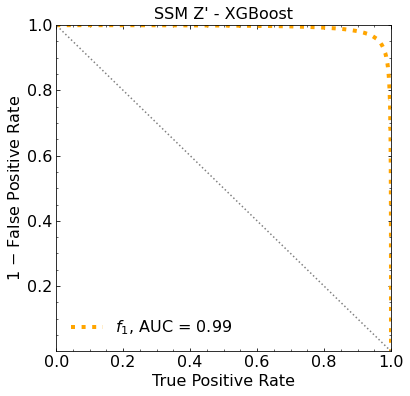

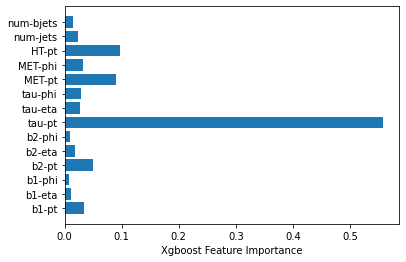

In [17]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"SSM Z' - XGBoost",fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()




# THIS IS THE DEFAULT FEATURE IMPORTANCE: gain
feature_names = np.array(['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets'])
plt.barh(feature_names, classifier.feature_importances_)
plt.xlabel("Xgboost Feature Importance")
plt.show()

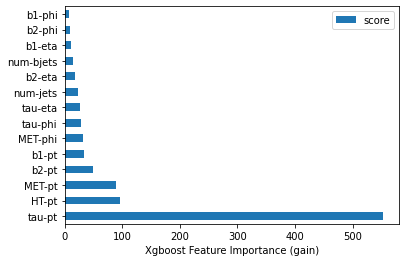

In [18]:
keys = np.array(['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets'])

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh') ## plot top 20 features
plt.xlabel("Xgboost Feature Importance (gain)")
plt.show()

Classification score:


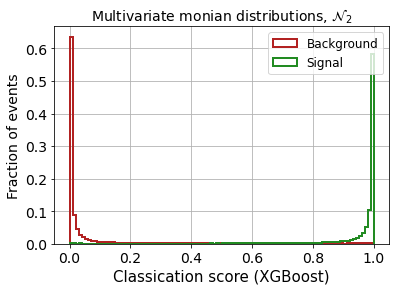

ROC AUC:        0.9914514341823529
ROC AUC upB:    0.9904223481984902
ROC AUC downB:  0.9924350946973114


In [19]:
# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Multivariate monian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2monian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()




# DATA WITH UNCERTAINTIES +1sigma

# PREDICTIONS
y_pred_xgupB = classifier.predict_proba(X_monupB_test).T[1]


# ROC
fpr_mon_xgupB, tpr_mon_xgupB, _ = roc_curve(y_monupB_test, y_pred_xgupB)
roc_auc_xgupB = auc(fpr_mon_xgupB, tpr_mon_xgupB)

# Outputs for validation data set

pred_XG_SMupB = []
pred_XG_NPupB = []

for i in range(len(y_monupB_test)):
    if y_monupB_test[i] == 0:
        pred_XG_SMupB.append(y_pred_xgupB[i])
    else:
        pred_XG_NPupB.append(y_pred_xgupB[i])




# DATA WITH UNCERTAINTIES -1sigma

# PREDICTIONS
y_pred_xgdownB = classifier.predict_proba(X_mondownB_test).T[1]

# ROC
fpr_mon_xgdownB, tpr_mon_xgdownB, _ = roc_curve(y_mondownB_test, y_pred_xgdownB)
roc_auc_xgdownB = auc(fpr_mon_xgdownB, tpr_mon_xgdownB)

# Outputs for validation data set

pred_XG_SMdownB = []
pred_XG_NPdownB = []

for i in range(len(y_mondownB_test)):
    if y_mondownB_test[i] == 0:
        pred_XG_SMdownB.append(y_pred_xgdownB[i])
    else:
        pred_XG_NPdownB.append(y_pred_xgdownB[i])
        
        
        
print('ROC AUC:       ',roc_auc_xg)
print('ROC AUC upB:   ',roc_auc_xgupB)
print('ROC AUC downB: ',roc_auc_xgdownB)

In [20]:
# we choose the worst one to be conservative

## METHODS

### 0. Ensembles characteristics

In [21]:
##############
# PARAMETERS #
##############

# requested number of ensembles
n_ensembles = 2000

# number of expected background events per ensemble
B_expected = round(139 * totalcrossSM)    # luminosity * cross * aceptance
print('B_expected: ', B_expected)

print('S_expected: ', round(139 * crossfidNP))    # luminosity * cross * aceptance
S_expected = [1,3,5,7,10,20,50,70]




# SOME USEFUL DERIVATED PARAMETERS:

# S/\sqrt{B}
SB_ratio = [ S_expected[iii]/(1.*B_expected) for iii in range(len(S_expected)) ]

# S/\sqrt{B}
SsqrtB = [ S_expected[iii]/(B_expected)**0.5 for iii in range(len(S_expected)) ]

B_expected:  1428
S_expected:  45


In [22]:
139 * crossfidNP

44.81687963956308

### 1. BIN LOG LIKELIHOOD

In [23]:
MIN_EVS = 5

# Les't find the number of possible ensembles
N_ensembles_back = int(len(pred_XG_SM) / B_expected)
N_events_back = N_ensembles_back * B_expected


for bin_it in range(10,100):
    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM[:N_events_back]], bins=(bin_it), range = [[0,1]])

    if min(hist_back) < MIN_EVS * N_ensembles_back:
        print('At least ' + str(MIN_EVS) + ' B events per bin, range = [[0,1]]:')
        print('# bins: ',bin_it,'NO ok')
        print(min(hist_back/N_ensembles_back))
        break
        
print('')

for bin_it in range(10,100):
    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM[:N_events_back]], bins=(bin_it), range = [[min(pred_XG_SM[:N_events_back]),max(pred_XG_SM[:N_events_back])]])

    if min(hist_back) < MIN_EVS * N_ensembles_back:
        print('At least ' + str(MIN_EVS) + ' B events per bin, range = [[min(B),max(B)]]:')
        print('# bins: ',bin_it,'NO ok')
        print(min(hist_back/N_ensembles_back))
        break

At least 5 B events per bin, range = [[0,1]]:
# bins:  22 NO ok
4.913793103448276

At least 5 B events per bin, range = [[min(B),max(B)]]:
# bins:  22 NO ok
4.905172413793103


In [ ]:
#################################
# BINNED POISSON LOG-LIKELIHOOD #
#################################

store_Z_bins_XG_16bins = []
store_Z_bins_XG_50bins = []
store_Z_bins_XG_100bins = []

store_Z_bins_XG_16bins_std = []
store_Z_bins_XG_50bins_std = []
store_Z_bins_XG_100bins_std = []

# store_Z_bins_XG_16bins_noUnc = []
# store_Z_bins_XG_50bins_noUnc = []
# store_Z_bins_XG_100bins_noUnc = []

# store_Z_bins_XG_16bins_noUnc_std = []
# store_Z_bins_XG_50bins_noUnc_std = []
# store_Z_bins_XG_100bins_noUnc_std = []


indices_B = [i for i in range(len(pred_XG_SM))]
indices_S = [i for i in range(len(pred_XG_NP))]



#################
# Uncertainties #
#################
# Les't use an integer number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_events_back = N_ensembles_back * B_expected

# Let's find out the expected number of B and S events in each bin:

# 16 bins #

# (upB type) #
# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SMupB], bins=(16), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom_upB = hist_back.T.ravel()/N_ensembles_back

# (downB type) #
# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SMdownB], bins=(16), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom_downB = hist_back.T.ravel()/N_ensembles_back

back_prom_sig_16bins = abs(back_prom_upB-back_prom_downB)/2
# If a bins has no expected background events replace that zero for the minimum B_bin=/=0
# find the minimum
back_prom_sig_16bins_noceros = []
for i in range(len(back_prom_sig_16bins)):
    if back_prom_sig_16bins[i]!=0:
        back_prom_sig_16bins_noceros.append(back_prom_sig_16bins[i])

min_back = min(back_prom_sig_16bins_noceros)

# replace the zeros
for i in range(len(back_prom_sig_16bins)):
    if back_prom_sig_16bins[i]==0:
        back_prom_sig_16bins[i] = min_back
        
        
        
# 50 bins #

# (upB type) #
# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SMupB], bins=(50), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom_upB = hist_back.T.ravel()/N_ensembles_back

# (downB type) #
# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SMdownB], bins=(50), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom_downB = hist_back.T.ravel()/N_ensembles_back

back_prom_sig_50bins = abs(back_prom_upB-back_prom_downB)/2
# If a bins has no expected background events replace that zero for the minimum B_bin=/=0
# find the minimum
back_prom_sig_50bins_noceros = []
for i in range(len(back_prom_sig_50bins)):
    if back_prom_sig_50bins[i]!=0:
        back_prom_sig_50bins_noceros.append(back_prom_sig_50bins[i])

min_back = min(back_prom_sig_50bins_noceros)

# replace the zeros
for i in range(len(back_prom_sig_50bins)):
    if back_prom_sig_50bins[i]==0:
        back_prom_sig_50bins[i] = min_back
        
        
        
        
# 100 bins #

# (upB type) #
# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SMupB], bins=(100), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom_upB = hist_back.T.ravel()/N_ensembles_back

# (downB type) #
# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SMdownB], bins=(100), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom_downB = hist_back.T.ravel()/N_ensembles_back

back_prom_sig_100bins = abs(back_prom_upB-back_prom_downB)/2
# If a bins has no expected background events replace that zero for the minimum B_bin=/=0
# find the minimum
back_prom_sig_100bins_noceros = []
for i in range(len(back_prom_sig_100bins)):
    if back_prom_sig_100bins[i]!=0:
        back_prom_sig_100bins_noceros.append(back_prom_sig_100bins[i])

min_back = min(back_prom_sig_100bins_noceros)

# replace the zeros
for i in range(len(back_prom_sig_100bins)):
    if back_prom_sig_100bins[i]==0:
        back_prom_sig_100bins[i] = min_back








for iii in range(len(S_expected)):

    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    
    
    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[iii] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[iii]/(S_expected[iii]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######
    
    
    print('\n This may take a bit... \n')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    Z_bins_16bins_aux = []
    Z_bins_50bins_aux = []
    Z_bins_100bins_aux = []
    
#     Z_bins_16bins_noUnc_aux = []
#     Z_bins_50bins_noUnc_aux = []
#     Z_bins_100bins_noUnc_aux = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):
            
            ran_ind_B = np.random.choice(indices_B, list_B_per_ensembles[bb])
            ran_ind_S = np.random.choice(indices_S, list_S_per_ensembles[bb])
            
            # estimate the variance in each bin as ~ (upB - downB)/2 
            
            pred_XG_SM_shuf = []
            
            pred_XG_NP_shuf = []
            
            for ill in ran_ind_B:
                pred_XG_SM_shuf.append(pred_XG_SM[ill])
                
            for ill in ran_ind_S:
                pred_XG_NP_shuf.append(pred_XG_NP[ill])
                
            
            
            ############
            # 16 bins #
            ############

            # Let's find out the expected number of B and S events in each bin:       

            # bin the parameter space of all background events
            hist_back, binedges_back = np.histogramdd([pred_XG_SM_shuf], bins=(16), range = [[0,1]])
            # now divide by the number of possible ensembles
            back_prom = hist_back.T.ravel()

            # same for signal
            hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_shuf], bins=(16), range = [[0,1]])
            sig_prom = hist_sig.T.ravel()



            # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

            # find the minimum
            back_prom_noceros = []
            for i in range(len(back_prom)):
                if back_prom[i]!=0:
                    back_prom_noceros.append(back_prom[i])

            min_back = min(back_prom_noceros)

            # replace the zeros
            for i in range(len(back_prom)):
                if back_prom[i]==0:
                    back_prom[i] = min_back
                    
                    
                    
#             ## then the signif Z^binned-Asimov without uncertainties:
#             Z_bins_16bins_noUnc = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

#             Z_bins_16bins_noUnc_aux.append(Z_bins_16bins_noUnc)
                    

            # then the signif Z^binned-Asimov with uncertainties in the background:

            B_hat = 0.5* ( (back_prom-sig_prom) + ((back_prom+sig_prom)**2. - ( (4.*back_prom*sig_prom*(back_prom_sig_16bins**2))/((back_prom_sig_16bins**2)+back_prom) ))**0.5 )

            Z_bins_16bins_sig = abs( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + B_hat) ) ) - ( (back_prom**2/(back_prom_sig_16bins**2))*np.log(B_hat/back_prom) ) + ( (B_hat-back_prom)*(1+(back_prom/(back_prom_sig_16bins**2))) ) + sig_prom ) )**0.5

            Z_bins_16bins_aux.append(Z_bins_16bins_sig)
            
            
            
            
            
            ############
            # 50 bins #
            ############

            # Let's find out the expected number of B and S events in each bin:

            # bin the parameter space of all background events
            hist_back, binedges_back = np.histogramdd([pred_XG_SM_shuf], bins=(50), range = [[0,1]])
            # now divide by the number of possible ensembles
            back_prom = hist_back.T.ravel()

            # same for signal
            hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_shuf], bins=(50), range = [[0,1]])
            sig_prom = hist_sig.T.ravel()



            # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

            # find the minimum
            back_prom_noceros = []
            for i in range(len(back_prom)):
                if back_prom[i]!=0:
                    back_prom_noceros.append(back_prom[i])

            min_back = min(back_prom_noceros)

            # replace the zeros
            for i in range(len(back_prom)):
                if back_prom[i]==0:
                    back_prom[i] = min_back
                    
                    
                    
#             ## then the signif Z^binned-Asimov without uncertainties:
#             Z_bins_50bins_noUnc = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

#             Z_bins_50bins_noUnc_aux.append(Z_bins_50bins_noUnc)
                    

            # then the signif Z^binned-Asimov with uncertainties in the background:

            B_hat = 0.5* ( (back_prom-sig_prom) + ((back_prom+sig_prom)**2. - ( (4.*back_prom*sig_prom*(back_prom_sig_50bins**2))/((back_prom_sig_50bins**2)+back_prom) ))**0.5 )

            Z_bins_50bins_sig = abs( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + B_hat) ) ) - ( (back_prom**2/(back_prom_sig_50bins**2))*np.log(B_hat/back_prom) ) + ( (B_hat-back_prom)*(1+(back_prom/(back_prom_sig_50bins**2))) ) + sig_prom ) )**0.5

            Z_bins_50bins_aux.append(Z_bins_50bins_sig)
        
        
        
        
        
        
            ############
            # 100 bins #
            ############

            # Let's find out the expected number of B and S events in each bin:

            # bin the parameter space of all background events
            hist_back, binedges_back = np.histogramdd([pred_XG_SM_shuf], bins=(100), range = [[0,1]])
            # now divide by the number of possible ensembles
            back_prom = hist_back.T.ravel()

            # same for signal
            hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_shuf], bins=(100), range = [[0,1]])
            sig_prom = hist_sig.T.ravel()



            # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

            # find the minimum
            back_prom_noceros = []
            for i in range(len(back_prom)):
                if back_prom[i]!=0:
                    back_prom_noceros.append(back_prom[i])

            min_back = min(back_prom_noceros)

            # replace the zeros
            for i in range(len(back_prom)):
                if back_prom[i]==0:
                    back_prom[i] = min_back
                    
                    
                    
#             ## then the signif Z^binned-Asimov without uncertainties:
#             Z_bins_100bins_noUnc = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

#             Z_bins_100bins_noUnc_aux.append(Z_bins_100bins_noUnc)
                    

            # then the signif Z^binned-Asimov with uncertainties in the background:

            B_hat = 0.5* ( (back_prom-sig_prom) + ((back_prom+sig_prom)**2. - ( (4.*back_prom*sig_prom*(back_prom_sig_100bins**2))/((back_prom_sig_100bins**2)+back_prom) ))**0.5 )

            Z_bins_100bins_sig = abs( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + B_hat) ) ) - ( (back_prom**2/(back_prom_sig_100bins**2))*np.log(B_hat/back_prom) ) + ( (B_hat-back_prom)*(1+(back_prom/(back_prom_sig_100bins**2))) ) + sig_prom ) )**0.5

            Z_bins_100bins_aux.append(Z_bins_100bins_sig)
            
    
    
    
  
    # Histogram of q_muhats

    weights = np.ones_like(Z_bins_16bins_aux)/float(len(Z_bins_16bins_aux))
    nMIX, binsMIX, patchesMIX = plt.hist(Z_bins_16bins_aux, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    weights = np.ones_like(Z_bins_50bins_aux)/float(len(Z_bins_50bins_aux))
    nMIX, binsMIX, patchesMIX = plt.hist(Z_bins_50bins_aux, 25, weights=weights, histtype='step', color='green', linewidth=2)
    weights = np.ones_like(Z_bins_100bins_aux)/float(len(Z_bins_100bins_aux))
    nMIX, binsMIX, patchesMIX = plt.hist(Z_bins_100bins_aux, 25, weights=weights, histtype='step', color='darkorange', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Z",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()
    
    
    # 16 bins #
    # Remove nan if any
    Z_bins_16bins_aux = [x for x in Z_bins_16bins_aux if x == x]
    for jk in range(len(Z_bins_16bins_aux)):
        if Z_bins_16bins_aux[jk] < 0:
            Z_bins_16bins_aux[jk] = 0

    Z_bins_16bins = np.median(Z_bins_16bins_aux)   
    store_Z_bins_XG_16bins.append(Z_bins_16bins)
    
    Z_bins_16bins_std = np.std(Z_bins_16bins_aux)   
    store_Z_bins_XG_16bins_std.append(Z_bins_16bins_std)

    print('Z_bins_16bins: ', Z_bins_16bins)
    print('Z_bins_16bins_std: ', Z_bins_16bins_std)

    
#     # Remove nan if any
#     Z_bins_16bins_noUnc_aux = [x for x in Z_bins_16bins_noUnc_aux if x == x]
#     for jk in range(len(Z_bins_16bins_noUnc_aux)):
#         if Z_bins_16bins_noUnc_aux[jk] < 0:
#             Z_bins_16bins_noUnc_aux[jk] = 0

#     Z_bins_16bins_noUnc = np.median(Z_bins_16bins_noUnc_aux)   
#     store_Z_bins_XG_16bins_noUnc.append(Z_bins_16bins_noUnc)
    
#     Z_bins_16bins_noUnc_std = np.std(Z_bins_16bins_noUnc_aux)   
#     store_Z_bins_XG_16bins_noUnc_std.append(Z_bins_16bins_noUnc_std)

#     print('Z_bins_16bins_noUnc: ', Z_bins_16bins_noUnc)
#     print('Z_bins_16bins_noUnc_std: ', Z_bins_16bins_noUnc_std)
    
    
    # 50 bins #
    # Remove nan if any
    Z_bins_50bins_aux = [x for x in Z_bins_50bins_aux if x == x]
    for jk in range(len(Z_bins_50bins_aux)):
        if Z_bins_50bins_aux[jk] < 0:
            Z_bins_50bins_aux[jk] = 0

    Z_bins_50bins = np.median(Z_bins_50bins_aux)   
    store_Z_bins_XG_50bins.append(Z_bins_50bins)
    
    Z_bins_50bins_std = np.std(Z_bins_50bins_aux)   
    store_Z_bins_XG_50bins_std.append(Z_bins_50bins_std)

    print('Z_bins_50bins: ', Z_bins_50bins)
    print('Z_bins_50bins_std: ', Z_bins_50bins_std)
    
    
#     # Remove nan if any
#     Z_bins_50bins_noUnc_aux = [x for x in Z_bins_50bins_noUnc_aux if x == x]
#     for jk in range(len(Z_bins_50bins_noUnc_aux)):
#         if Z_bins_50bins_noUnc_aux[jk] < 0:
#             Z_bins_50bins_noUnc_aux[jk] = 0

#     Z_bins_50bins_noUnc = np.median(Z_bins_50bins_noUnc_aux)   
#     store_Z_bins_XG_50bins_noUnc.append(Z_bins_50bins_noUnc)
    
#     Z_bins_50bins_noUnc_std = np.std(Z_bins_50bins_noUnc_aux)   
#     store_Z_bins_XG_50bins_noUnc_std.append(Z_bins_50bins_noUnc_std)

#     print('Z_bins_50bins_noUnc: ', Z_bins_50bins_noUnc)
#     print('Z_bins_50bins_noUnc_std: ', Z_bins_50bins_noUnc_std)
    
    
    # 100 bins #
    # Remove nan if any
    Z_bins_100bins_aux = [x for x in Z_bins_100bins_aux if x == x]
    for jk in range(len(Z_bins_100bins_aux)):
        if Z_bins_100bins_aux[jk] < 0:
            Z_bins_100bins_aux[jk] = 0

    Z_bins_100bins = np.median(Z_bins_100bins_aux)   
    store_Z_bins_XG_100bins.append(Z_bins_100bins)
    
    Z_bins_100bins_std = np.std(Z_bins_100bins_aux)   
    store_Z_bins_XG_100bins_std.append(Z_bins_100bins_std)

    print('Z_bins_100bins: ', Z_bins_100bins)
    print('Z_bins_100bins_std: ', Z_bins_100bins_std)
    
    
#     # Remove nan if any
#     Z_bins_100bins_noUnc_aux = [x for x in Z_bins_100bins_noUnc_aux if x == x]
#     for jk in range(len(Z_bins_100bins_noUnc_aux)):
#         if Z_bins_100bins_noUnc_aux[jk] < 0:
#             Z_bins_100bins_noUnc_aux[jk] = 0

#     Z_bins_100bins_noUnc = np.median(Z_bins_100bins_noUnc_aux)   
#     store_Z_bins_XG_100bins_noUnc.append(Z_bins_100bins_noUnc)
    
#     Z_bins_100bins_noUnc_std = np.std(Z_bins_100bins_noUnc_aux)   
#     store_Z_bins_XG_100bins_noUnc_std.append(Z_bins_100bins_noUnc_std)

#     print('Z_bins_100bins_noUnc: ', Z_bins_100bins_noUnc)
#     print('Z_bins_100bins_noUnc_std: ', Z_bins_100bins_noUnc_std)

    print('\n -------------------------------- \n')

In [ ]:
print(store_Z_bins_XG_16bins)
print(store_Z_bins_XG_50bins)
print(store_Z_bins_XG_100bins)

print(store_Z_bins_XG_16bins_std)
print(store_Z_bins_XG_50bins_std)
print(store_Z_bins_XG_100bins_std)

In [24]:
store_Z_bins_XG_16bins = [0.0, 0.5514300713491351, 0.93426743451932, 1.2941106316707591, 1.794910114411375, 3.3232970011504634, 6.704379130511585, 8.485757050616996]
store_Z_bins_XG_50bins = [0.0, 0.8651804780649481, 1.344155692175947, 1.7812394413682708, 2.3884252393762555, 4.007636660434341, 7.442061267699151, 9.204817449917917]
store_Z_bins_XG_100bins = [0.0, 1.079574987993231, 1.5647272199901376, 2.0162777671252035, 2.630415948085315, 4.290891764688148, 7.665004979396428, 9.416344977421996]

store_Z_bins_XG_16bins_std = [0.13508103473071068, 0.129227396147884, 0.17823304426604636, 0.20747268342219455, 0.2588452823217264, 0.35405869643327226, 0.425823979553387, 0.44071411614308686]
store_Z_bins_XG_50bins_std = [0.24416907066787624, 0.21506384822884053, 0.275427352887796, 0.3075976068271481, 0.3572304266266148, 0.4227931591852579, 0.4415186436111001, 0.44770688177434625]
store_Z_bins_XG_100bins_std =[0.3135675404649822, 0.2313698181406138, 0.28983495808164933, 0.3160230007836697, 0.3546342689951514, 0.3979932327366788, 0.4069453214973536, 0.4066268641032727]

B_expected:  1428
S_expected:  1
S/$\sqrt{B}$:  0.026462806201248155


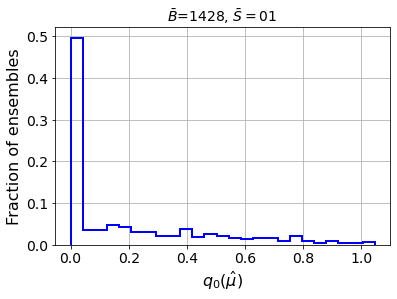

bins:  16
muhat mean:  0.0980378567652165
median q_muhat_16bins:  0.05014166207703319
Z_16bins:  0.22392333973267098
Z_16bins mu=0:  0.22391275311699108
std Z_16bins:  0.5793700350611846
std Z_16bins mu=0:  0.5800521304904308


 -------------------------------- 

B_expected:  1428
S_expected:  3
S/$\sqrt{B}$:  0.07938841860374447


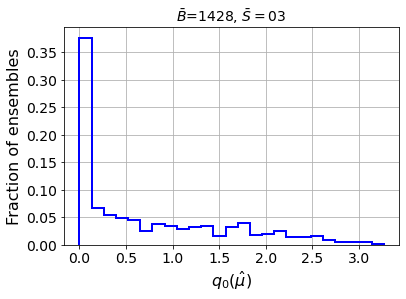

bins:  16
muhat mean:  0.02557265344241364
median q_muhat_16bins:  0.41431320100335256
Z_16bins:  0.6436716562062933
Z_16bins mu=0:  0.643617275283184
std Z_16bins:  0.6403432589546464
std Z_16bins mu=0:  0.6465574525060188


 -------------------------------- 

B_expected:  1428
S_expected:  5
S/$\sqrt{B}$:  0.13231403100624078


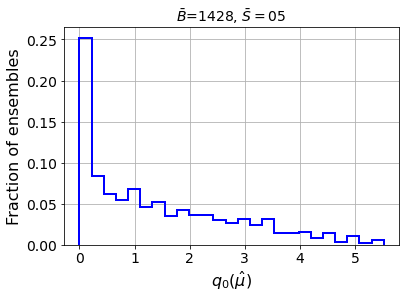

bins:  16
muhat mean:  0.0360401825493132
median q_muhat_16bins:  1.036935184124573
Z_16bins:  1.018300144419401
Z_16bins mu=0:  1.017852629403653
std Z_16bins:  0.6670876405386548
std Z_16bins mu=0:  0.6818300347877584


 -------------------------------- 

B_expected:  1428
S_expected:  7
S/$\sqrt{B}$:  0.18523964340873708


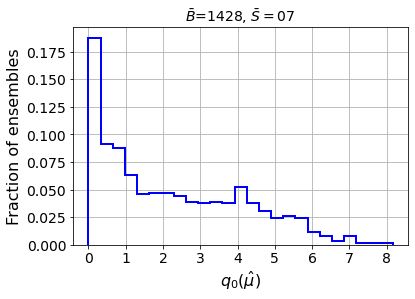

bins:  16
muhat mean:  0.06424673956777006
median q_muhat_16bins:  1.7901443142257243
Z_16bins:  1.3379627476973057
Z_16bins mu=0:  1.335540513251765
std Z_16bins:  0.7163363189046205
std Z_16bins mu=0:  0.7482894815283799


 -------------------------------- 

B_expected:  1428
S_expected:  10
S/$\sqrt{B}$:  0.26462806201248157


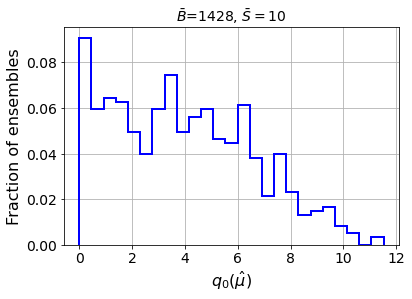

bins:  16
muhat mean:  0.03415324575341139
median q_muhat_16bins:  3.6814122807414575
Z_16bins:  1.9187006751292546
Z_16bins mu=0:  1.9186299768452069
std Z_16bins:  0.6919713770688211
std Z_16bins mu=0:  0.7375432717952378


 -------------------------------- 

B_expected:  1428
S_expected:  20
S/$\sqrt{B}$:  0.5292561240249631


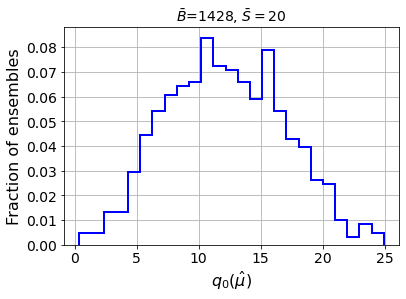

bins:  16
muhat mean:  -0.0005424811210322519
median q_muhat_16bins:  12.009795103499497
Z_16bins:  3.4655151281590877
Z_16bins mu=0:  3.4655151281590877
std Z_16bins:  0.681238213811601
std Z_16bins mu=0:  0.7505489975685296


 -------------------------------- 

B_expected:  1428
S_expected:  50
S/$\sqrt{B}$:  1.3231403100624077


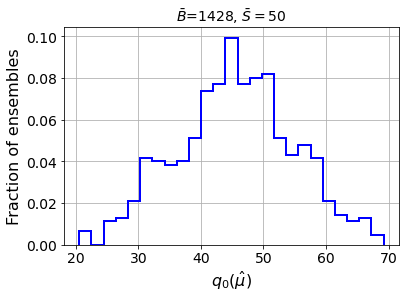

bins:  16
muhat mean:  0.006794730530553179
median q_muhat_16bins:  45.63929522636988
Z_16bins:  6.755686140309501
Z_16bins mu=0:  6.755564294868271
std Z_16bins:  0.6852493636384361
std Z_16bins mu=0:  0.7459728533298476


 -------------------------------- 

B_expected:  1428
S_expected:  70
S/$\sqrt{B}$:  1.8523964340873709


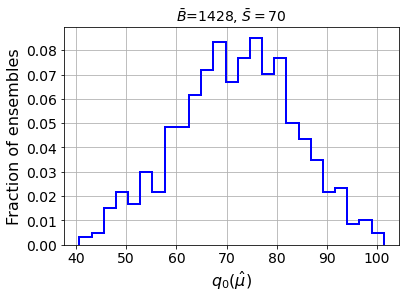

bins:  16
muhat mean:  0.006207690455284918
median q_muhat_16bins:  72.45615934710902
Z_16bins:  8.512118381878215
Z_16bins mu=0:  8.509626314243814
std Z_16bins:  0.6879443274335981
std Z_16bins mu=0:  0.7430823570736946


 -------------------------------- 

[0.0980378567652165, 0.02557265344241364, 0.0360401825493132, 0.06424673956777006, 0.03415324575341139, -0.0005424811210322519, 0.006794730530553179, 0.006207690455284918]
[0.22392333973267098, 0.6436716562062933, 1.018300144419401, 1.3379627476973057, 1.9187006751292546, 3.4655151281590877, 6.755686140309501, 8.512118381878215]
[0.5793700350611846, 0.6403432589546464, 0.6670876405386548, 0.7163363189046205, 0.6919713770688211, 0.681238213811601, 0.6852493636384361, 0.6879443274335981]
[0.22391275311699108, 0.643617275283184, 1.017852629403653, 1.335540513251765, 1.9186299768452069, 3.4655151281590877, 6.755564294868271, 8.509626314243814]
[0.5800521304904308, 0.6465574525060188, 0.6818300347877584, 0.7482894815283799, 0.737543271

In [25]:
#################################
# BINNED POISSON LOG-LIKELIHOOD #
#################################

store_muhat_mean_16bins  = []

store_Z_bins_XG_16bins_q = []
store_Z_bins_XG_16bins_std = []

store_Z_bins_XG_16bins_mu0 = []
store_Z_bins_XG_16bins_std_mu0 = []




hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(16), range = [[0,1]])
bin_edges = binedges_back[0]
back_prom_16bins = hist_back.T.ravel() / (len(pred_XG_SM) / B_expected)

# find the minimum
back_prom_noceros = []
for i in range(len(back_prom_16bins)):
    if back_prom_16bins[i]!=0:
        back_prom_noceros.append(back_prom_16bins[i])

min_back = min(back_prom_noceros)

# replace the zeros
for i in range(len(back_prom_16bins)):
    if back_prom_16bins[i]==0:
        back_prom_16bins[i] = min_back
        
        






for iii in range(len(S_expected)):

    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    

    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(16), range = [[0,1]])
    sig_prom_16bins = hist_sig.T.ravel() / (len(pred_XG_NP) / S_expected[iii])
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    muhat_selected_16bins_list = []
    q_muhat_16bins = []
    q_muhat_16bins_mu0 = []
    
    
    for its in range(n_ensembles):
        
        B_rand = np.random.poisson(int(B_expected))
        
        pred_XG_SM_shuf = np.random.choice(pred_XG_SM, size = B_rand, replace = False)
            
        pseudo_exp = pred_XG_SM_shuf


        ############
        # 16 bins #
        ############

        # Let's find out the expected number of B and S events in each bin:

        # bin the parameter space of all background events
        hist_N, binedges_N = np.histogramdd([pseudo_exp], bins=(16), range = [[0,1]])
        # now divide by the number of possible ensembles
        N_pseudo = hist_N.T.ravel()

        if min(N_pseudo) >= MIN_EVS:
                
            # approximation: mu_hat=0
            q_muhat_16bins_mu0.append( -2 * sum([( (ni * np.log( ((1.*si)+bi)/((0.*si)+bi) ) ) - ((1.*si)+bi) + ((0.*si)+bi) ) for ni, si, bi in zip(N_pseudo, sig_prom_16bins, back_prom_16bins)]) )

                
            # compute mu_hat from implicit equation
            def f_mu_hat(mu_h, N_pseudo=N_pseudo, sig_prom_16bins=sig_prom_16bins, back_prom_16bins=back_prom_16bins):
                return sum ( [((ni*si) / ((mu_h*si) + bi)) - si for ni, si, bi in zip(N_pseudo, sig_prom_16bins, back_prom_16bins)] )

        
            muhat_selected_16bins = fsolve(f_mu_hat,0)[0]
            
            muhat_selected_16bins_list.append(muhat_selected_16bins)

                
            if muhat_selected_16bins > 1:
                q_muhat_16bins.append( 0 )
                    
            elif muhat_selected_16bins > 0:
                q_muhat_16bins.append( -2 * sum([( (ni * np.log( ((1.*si)+bi)/((muhat_selected_16bins*si)+bi) ) ) - ((1.*si)+bi) + ((muhat_selected_16bins*si)+bi) ) for ni, si, bi in zip(N_pseudo, sig_prom_16bins, back_prom_16bins)]) )

            else:
                q_muhat_16bins.append( -2 * sum([( (ni * np.log( ((1.*si)+bi)/((0.*si)+bi) ) ) - ((1.*si)+bi) + ((0.*si)+bi) ) for ni, si, bi in zip(N_pseudo, sig_prom_16bins, back_prom_16bins)]) )

            
            
        
        
    # Histogram of q_muhats

    weights = np.ones_like(q_muhat_16bins)/float(len(q_muhat_16bins))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_16bins, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()

    
    

    # Finally calculate muhat_mean and Z_gaussian
    
    # 16 bins #
    # Remove nan if any
    q_muhat_16bins_mu0 = [x for x in q_muhat_16bins_mu0 if x == x]
    for jk in range(len(q_muhat_16bins_mu0)):
        if q_muhat_16bins_mu0[jk] < 0:
            q_muhat_16bins_mu0[jk] = 0

    q_muhat_16bins_median_mu0 = np.median(q_muhat_16bins_mu0)
    Z_16bins_mu0 = abs(q_muhat_16bins_median_mu0)**0.5
    store_Z_bins_XG_16bins_mu0.append(Z_16bins_mu0)
    
    q_muhat_16bins_std_mu0 = np.std(q_muhat_16bins_mu0)
    Z_16bins_std_mu0 = q_muhat_16bins_std_mu0/(2.*Z_16bins_mu0)
    store_Z_bins_XG_16bins_std_mu0.append(Z_16bins_std_mu0)
    

    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean_16bins = np.mean(muhat_selected_16bins_list)
    store_muhat_mean_16bins.append(muhat_mean_16bins)

    # Remove nan if any
    q_muhat_16bins = [x for x in q_muhat_16bins if x == x]
    for jk in range(len(q_muhat_16bins)):
        if q_muhat_16bins[jk] < 0:
            q_muhat_16bins[jk] = 0

    q_muhat_16bins_median = np.median(q_muhat_16bins)
    Z_16bins = abs(q_muhat_16bins_median)**0.5
    store_Z_bins_XG_16bins_q.append(Z_16bins)
    
    q_muhat_16bins_std = np.std(q_muhat_16bins)
    Z_16bins_std = q_muhat_16bins_std/(2.*Z_16bins)
    store_Z_bins_XG_16bins_std.append(Z_16bins_std)

    print('bins: ', 16)
    print('muhat mean: ', muhat_mean_16bins)
    print('median q_muhat_16bins: ', q_muhat_16bins_median)
    print('Z_16bins: ', Z_16bins)
    print('Z_16bins mu=0: ', Z_16bins_mu0)
    print('std Z_16bins: ', Z_16bins_std)
    print('std Z_16bins mu=0: ', Z_16bins_std_mu0)
    print('')
    
    

    print('\n -------------------------------- \n')
    

print(store_muhat_mean_16bins)

print(store_Z_bins_XG_16bins_q)
print(store_Z_bins_XG_16bins_std)

print(store_Z_bins_XG_16bins_mu0)
print(store_Z_bins_XG_16bins_std_mu0)

In [28]:
store_muhat_mean_16bins = [0.0980378567652165, 0.02557265344241364, 0.0360401825493132, 0.06424673956777006, 0.03415324575341139, -0.0005424811210322519, 0.006794730530553179, 0.006207690455284918]

store_Z_bins_XG_16bins_q = [0.22392333973267098, 0.6436716562062933, 1.018300144419401, 1.3379627476973057, 1.9187006751292546, 3.4655151281590877, 6.755686140309501, 8.512118381878215]
store_Z_bins_XG_16bins_std = [0.5793700350611846, 0.6403432589546464, 0.6670876405386548, 0.7163363189046205, 0.6919713770688211, 0.681238213811601, 0.6852493636384361, 0.6879443274335981]

store_Z_bins_XG_16bins_mu0 = [0.22391275311699108, 0.643617275283184, 1.017852629403653, 1.335540513251765, 1.9186299768452069, 3.4655151281590877, 6.755564294868271, 8.509626314243814]
store_Z_bins_XG_16bins_std_mu0 = [0.5800521304904308, 0.6465574525060188, 0.6818300347877584, 0.7482894815283799, 0.7375432717952378, 0.7505489975685296, 0.7459728533298476, 0.7430823570736946]

In [26]:
store_Z_bins_XG_16bins_plus = [i+j for i, j in zip(store_Z_bins_XG_16bins, store_Z_bins_XG_16bins_std)]
store_Z_bins_XG_16bins_min = [i-j for i, j in zip(store_Z_bins_XG_16bins, store_Z_bins_XG_16bins_std)]

store_Z_bins_XG_50bins_plus = [i+j for i, j in zip(store_Z_bins_XG_50bins, store_Z_bins_XG_50bins_std)]
store_Z_bins_XG_50bins_min = [i-j for i, j in zip(store_Z_bins_XG_50bins, store_Z_bins_XG_50bins_std)]

store_Z_bins_XG_100bins_plus = [i+j for i, j in zip(store_Z_bins_XG_100bins, store_Z_bins_XG_100bins_std)]
store_Z_bins_XG_100bins_min = [i-j for i, j in zip(store_Z_bins_XG_100bins, store_Z_bins_XG_100bins_std)]

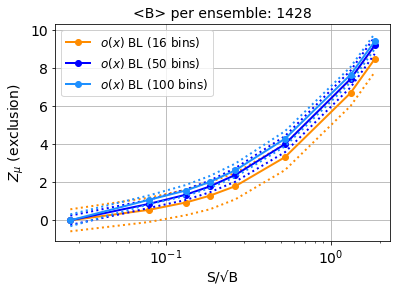

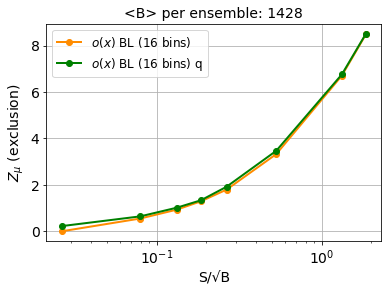

In [27]:
#########
# PLOTS #
#########

posX = []

for i in range(len(S_expected)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )


    
plt.figure()
lw = 2

plt.plot(posX, store_Z_bins_XG_16bins, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(posX, store_Z_bins_XG_16bins_plus, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_16bins_min, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)') 
plt.plot(posX, store_Z_bins_XG_50bins_plus, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins_min, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins, '-o', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)') 
plt.plot(posX, store_Z_bins_XG_100bins_plus, ':', color='dodgerblue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins_min, ':', color='dodgerblue', lw=lw) 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()





plt.figure()
lw = 2

plt.plot(posX, store_Z_bins_XG_16bins, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(posX, store_Z_bins_XG_16bins_q, '-o', color='green', lw=lw, label=r'$o(x)$ BL (16 bins) q') 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### MLL KDE

#### KDE

In [ ]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs



# # FIND THE BANDWIDTH

#SM_bandwidth = 0.0127
#NP_bandwidth = 0.0127

bandwidth = np.logspace(-4.0, 0.05, 20)

kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_SM[:20000]])
print('Background: ', grid.best_estimator_)

SM_bandwidth = grid.best_estimator_.bandwidth



kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_NP[:20000]])
print('Signal: ', grid.best_estimator_)

NP_bandwidth = grid.best_estimator_.bandwidth



# with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
# notice: epanechnikov kernel
kde_bkg = KernelDensity(kernel="epanechnikov", bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
kde_sig = KernelDensity(kernel="epanechnikov", bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])



# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
#plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# We can do a quick Z bin-loglikelihood calculation using the computed KDE
# this is to check the KDE here, because we use KDE to avoid binning


# in each ensemble we use B=50k
print('B_expected: ', B_expected)

# values of S / sqrt{B} to test 
soversqrtB = np.linspace(SsqrtB[0],SsqrtB[-1],100)



# Let's find out the expected number of B and S events in each bin:

# total number of B * B_pdf value in each bin * bin size
Bd = B_expected*dens_bkg*(s_vals[1]-s_vals[0])



# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
Bd_noceros = []
for i in range(len(Bd)):
    if Bd[i]!=0:
        Bd_noceros.append(Bd[i])

min_back = min(Bd_noceros)

# replace the zeros
for i in range(len(Bd)):
    if Bd[i]==0:
        Bd[i] = min_back




# Now calculate Z using the Binned Likelihood formula

Zvals = np.zeros(len(soversqrtB))

for nval, val in enumerate(soversqrtB):
    # S events in each bin: 
    # value of S/sqrt{B} * sqrt{B} * S_pdf value in each bin * bin size
    Sd = val*np.sqrt(B_expected)*dens_sig*(s_vals[1]-s_vals[0])
    
    # Z value:
    #Zvals[nval]= np.sqrt(2.0*np.sum(((Sd+Bd)*np.log(1.0+Sd/Bd)-Sd))) # Discovery
    Zvals[nval]= np.sqrt(2.0*np.sum(Bd*np.log(Bd/(Sd+Bd))+Sd)) # Exclusion

    
    
    
# PLOT

plt.figure()
lw = 2

plt.plot(posX, store_Z_bins_XG_16bins, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(posX, store_Z_bins_XG_50bins, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)') 
plt.plot(posX, store_Z_bins_XG_100bins, '-o', color='red', lw=lw, label=r'$o(x)$ BL (100 bins)') 
plt.plot(soversqrtB, Zvals, color='magenta', label=r'KDE$(\bar{x})$ Binned Likelihood') 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

#### MLL KDE

In [ ]:
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

In [ ]:
#################################################
# Uncertainties in tau pT using the dataset upB #
#################################################

KDE_SM_pred_SMupB = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SMupB, np.zeros(len(pred_XG_SMupB)) ]) )
KDE_NP_pred_SMupB = np.exp(kde_sig.score_samples(np.c_[pred_XG_SMupB, np.ones(len(pred_XG_SMupB)) ]) )


# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SMupB / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SMupB / factor_aux_NP

In [ ]:
store_muhat_mean_MLL_KDE = []

store_Z_MLL_KDE = []
store_Z_MLL_KDE_mu0 = []

store_Z_MLL_KDE_std = []
store_Z_MLL_KDE_std_mu0 = []


indices = [i for i in range(len(KDE_NP_pred_SM))]


for iii in range(len(SB_ratio)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    print('n_ensembles (initial): ', n_ensembles)


    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[iii] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[iii]/(S_expected[iii]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######



    print('\n This may take long... \n')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    muhat_selected_KDE_list = []
    q_muhat_KDE = []
    q_muhat_KDE_mu0 = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):
            
            # KDE
            ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

            KDE_SM_pred_SM_shuf = []
            KDE_NP_pred_SM_shuf = []

            for i in ran_ind:
                KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
                KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

            KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
            KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)





            # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

            # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )



            

            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
            
            sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
            sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            # grid, mu_hat is around 1
            muhat_test = np.arange(0., 1., 0.05).tolist()

            muhat_selected_KDE = 0.0

            if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 > 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break

            elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 < 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break


            muhat_selected_KDE_list.append(muhat_selected_KDE)



            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            #q_muhat_mu0.append( 2 * ( (-1.*1. * S_expected[iii]) + sum( [np.log( 1 + ( (1.*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            # EXCLUSION:
            q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (0.*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


    # Histogram of q_muhats

    weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()


    # Finally calculate muhat_mean and Z_gaussian
    
    # Remove nan if any
    q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]
    for jk in range(len(q_muhat_KDE_mu0)):
        if q_muhat_KDE_mu0[jk] < 0:
            q_muhat_KDE_mu0[jk] = 0

    q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)
    Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
    store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)
    
    q_muhat_KDE_std_mu0 = np.std(q_muhat_KDE_mu0)
    Z_KDE_std_mu0 = q_muhat_KDE_std_mu0/(2.*Z_KDE_mu0)
    store_Z_MLL_KDE_std_mu0.append(Z_KDE_std_mu0)
    

    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
    store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)

    # Remove nan if any
    q_muhat_KDE = [x for x in q_muhat_KDE if x == x]
    for jk in range(len(q_muhat_KDE)):
        if q_muhat_KDE[jk] < 0:
            q_muhat_KDE[jk] = 0

    q_muhat_KDE_median = np.median(q_muhat_KDE)
    Z_KDE = abs(q_muhat_KDE_median)**0.5
    store_Z_MLL_KDE.append(Z_KDE)
    
    q_muhat_KDE_std = np.std(q_muhat_KDE)
    Z_KDE_std = q_muhat_KDE_std/(2.*Z_KDE)
    store_Z_MLL_KDE_std.append(Z_KDE_std)

    print('muhat mean: ', muhat_mean_MLL_KDE)
    print('median q_muhat_KDE: ', q_muhat_KDE_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE mu=0: ', Z_KDE_mu0)
    print('std Z_KDE: ', Z_KDE_std)
    print('std Z_KDE mu=0: ', Z_KDE_std_mu0)

    print('\n -------------------------------- \n')

In [ ]:
print(store_muhat_mean_MLL_KDE)

print(store_Z_MLL_KDE)
print(store_Z_MLL_KDE_mu0)

print(store_Z_MLL_KDE_std)
print(store_Z_MLL_KDE_std_mu0)

In [28]:
# To use if you dont want to run everything again. Its the previous results
store_muhat_mean_MLL_KDE = [0.05564775160599572, 0.12847965738758033, 0.16677384780278673, 0.17956614890198178, 0.15227637921799683, 0.08214668094218416, 0.041492216854535705, 0.033645109567076434]

store_Z_MLL_KDE = [0.2761749332373654, 0.8201686803442492, 1.2650416470701886, 1.7123697587334812, 2.2436749613173133, 3.8197930134534857, 7.0433452057282215, 8.754752050100347]
store_Z_MLL_KDE_mu0 = [0.27467029794793624, 0.8198509258798691, 1.2625086721734022, 1.710051147078076, 2.2382816540000303, 3.817959276027647, 7.049427101245273, 8.766711922947453]

store_Z_MLL_KDE_std = [0.6002606907763164, 0.6078572035224986, 0.6472301895203675, 0.6760845669600221, 0.6913592675436522, 0.6918439097751536, 0.6444140467476963, 0.6254833864230039]
store_Z_MLL_KDE_std_mu0 = [0.6048106339638022, 0.6170988707840773, 0.6717078958355485, 0.719266540456948, 0.7555918960216346, 0.781012990873636, 0.6952634907293157, 0.6681725445509663]

In [29]:
store_Z_MLL_KDE_plus = [i+j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]
store_Z_MLL_KDE_min = [i-j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]

store_Z_MLL_KDE_mu0_plus = [i+j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]
store_Z_MLL_KDE_mu0_min = [i-j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]

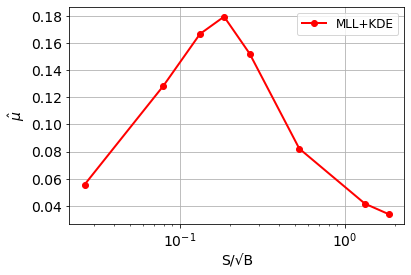

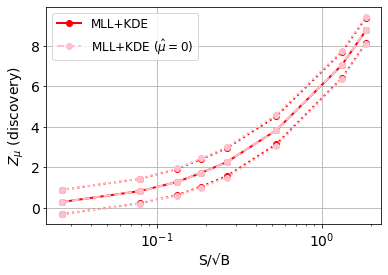

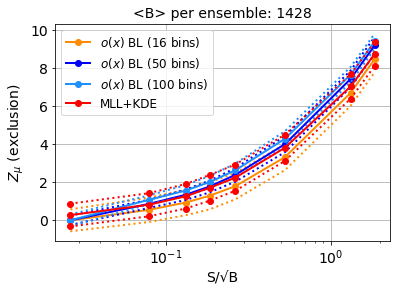

In [30]:
#########
# PLOTS #
#########

posX = []

for i in range(len(SB_ratio)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )




plt.figure()
lw = 2

plt.plot(posX, store_muhat_mean_MLL_KDE, '-o', color='red', lw=lw, label='MLL+KDE')

#plt.xlim([0.5, 100])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel(r'$\hat{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper right", fontsize=12)
plt.show()




plt.figure()
lw = 2

plt.plot(posX, store_Z_MLL_KDE, '-o', color='red', lw=lw, label='MLL+KDE')
plt.plot(posX, store_Z_MLL_KDE_plus, ':o', color='red', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_min, ':o', color='red', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_mu0, '--o', color='pink', lw=lw, label=r'MLL+KDE ($\hat{\mu}=0$)')
plt.plot(posX, store_Z_MLL_KDE_mu0_plus, ':o', color='pink', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_mu0_min, ':o', color='pink', lw=lw)

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()




plt.figure()
lw = 2

plt.plot(posX, store_Z_bins_XG_16bins, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(posX, store_Z_bins_XG_16bins_plus, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_16bins_min, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)') 
plt.plot(posX, store_Z_bins_XG_50bins_plus, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins_min, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins, '-o', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)') 
plt.plot(posX, store_Z_bins_XG_100bins_plus, ':', color='dodgerblue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins_min, ':', color='dodgerblue', lw=lw) 
plt.plot(posX, store_Z_MLL_KDE, '-o', color='red', lw=lw, label='MLL+KDE')
plt.plot(posX, store_Z_MLL_KDE_plus, ':o', color='red', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_min, ':o', color='red', lw=lw)

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### Interpolate

In [31]:
# if Z < 0 -> Z=0

store_Z_bins_XG_16bins = [0 if i < 0 else i for i in store_Z_bins_XG_16bins]
store_Z_bins_XG_16bins_plus = [0 if i < 0 else i for i in store_Z_bins_XG_16bins_plus]
store_Z_bins_XG_16bins_min = [0 if i < 0 else i for i in store_Z_bins_XG_16bins_min]

store_Z_bins_XG_50bins = [0 if i < 0 else i for i in store_Z_bins_XG_50bins]
store_Z_bins_XG_50bins_plus = [0 if i < 0 else i for i in store_Z_bins_XG_50bins_plus]
store_Z_bins_XG_50bins_min = [0 if i < 0 else i for i in store_Z_bins_XG_50bins_min]

store_Z_bins_XG_100bins = [0 if i < 0 else i for i in store_Z_bins_XG_100bins]
store_Z_bins_XG_100bins_plus = [0 if i < 0 else i for i in store_Z_bins_XG_100bins_plus]
store_Z_bins_XG_100bins_min = [0 if i < 0 else i for i in store_Z_bins_XG_100bins_min]

store_Z_MLL_KDE = [0 if i < 0 else i for i in store_Z_MLL_KDE]
store_Z_MLL_KDE_plus = [0 if i < 0 else i for i in store_Z_MLL_KDE_plus]
store_Z_MLL_KDE_min = [0 if i < 0 else i for i in store_Z_MLL_KDE_min]

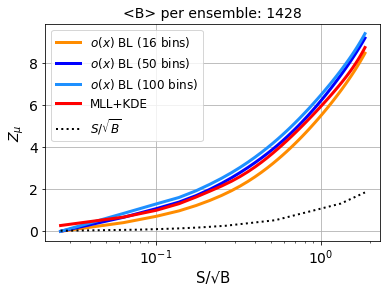

In [32]:
  
# Interpolation, cubic
f_16bins = interp1d(posX, store_Z_bins_XG_16bins, kind='cubic')
f_16bins_plus = interp1d(posX, store_Z_bins_XG_16bins_plus, kind='cubic')
f_16bins_min = interp1d(posX, store_Z_bins_XG_16bins_min, kind='cubic')

f_50bins = interp1d(posX, store_Z_bins_XG_50bins, kind='cubic')
f_50bins_plus = interp1d(posX, store_Z_bins_XG_50bins_plus, kind='cubic')
f_50bins_min = interp1d(posX, store_Z_bins_XG_50bins_min, kind='cubic')

f_100bins = interp1d(posX, store_Z_bins_XG_100bins, kind='cubic')
f_100bins_plus = interp1d(posX, store_Z_bins_XG_100bins_plus, kind='cubic')
f_100bins_min = interp1d(posX, store_Z_bins_XG_100bins_min, kind='cubic')

f_MLL_KDE = interp1d(posX, store_Z_MLL_KDE, kind='cubic')
f_MLL_KDE_plus = interp1d(posX, store_Z_MLL_KDE_plus, kind='cubic')
f_MLL_KDE_min = interp1d(posX, store_Z_MLL_KDE_min, kind='cubic')



# x to plot
plotX = np.linspace(min(posX), max(posX), num=50, endpoint=True)



plt.figure()
lw = 2

plt.plot(plotX, f_16bins(plotX), '-', color='darkorange', lw=3, label=r'$o(x)$ BL (16 bins)')
plt.plot(plotX, f_50bins(plotX), '-', color='blue', lw=3, label=r'$o(x)$ BL (50 bins)')
plt.plot(plotX, f_100bins(plotX), '-', color='dodgerblue', lw=3, label=r'$o(x)$ BL (100 bins)')
plt.plot(plotX, f_MLL_KDE(plotX), '-', color='red', lw=3, label='MLL+KDE')
plt.plot(posX, posX, ':', color='black', lw=lw, label=r'$S/\sqrt{B}$')

#plt.ylim([0., 6])
#plt.xlim([0.06, 10])
#plt.ylim([0., 3])
#plt.xlim([0.1, 0.2])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=15)
plt.ylabel('$Z_{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [33]:
# AUX FUNCTION TO FIND SOLUTIONS

def dx(fn, x, delta=0.001):
    return (fn(x+delta) - fn(x))/delta

def solve(fn, value, x=0.1, maxtries=1000, maxerr=0.00001):
    for tries in range(maxtries):
        err = fn(x) - value
        if abs(err) < maxerr:
            return x
        slope = dx(fn, x)
        x -= err/slope
    raise ValueError('no solution found')

In [34]:
# We need the ratio of the fiducial cross-sections for different values of beta to rescale

beta = [0,0.1,0.3,0.5,0.7,0.9,1]

# m_LQ = [ 800, 1000, 1200, 1400, 1600, 1800 ]  GeV
ind_mass = 1

fidcross_beta00 = [0.1271808, 0.027032160000000003, 0.00770688, 0.001878312, 0.0005908139999999999, 0.00017041759999999998]
fidcross_beta01 = [0.3163628, 0.0741753, 0.01952626, 0.0044892, 0.0016499700000000002, 0.00046830800000000007]
fidcross_beta03 = [0.559062, 0.13798409999999997, 0.03652792, 0.01062024, 0.002733768, 0.0008702760000000001]
fidcross_beta05 = [0.74664, 0.1822585, 0.04825368, 0.012417530000000001, 0.0032513399999999997, 0.001112082]
fidcross_beta07 = [0.6483749999999999, 0.165285, 0.04282562, 0.01281222, 0.003864048, 0.001097392]
fidcross_beta09 = [0.43799099999999996, 0.113778, 0.03572283, 0.010101599999999999, 0.0030826390000000003, 0.0008606400000000001]
fidcross_beta1 = [0.26443679999999997, 0.08237423999999999, 0.026599559999999994, 0.007674479999999999, 0.00222552, 0.0007910968]


S00 = round(139 * crossfidNP) * (fidcross_beta00[ind_mass]/fidcross_beta05[ind_mass])
S01 = round(139 * crossfidNP) * (fidcross_beta01[ind_mass]/fidcross_beta05[ind_mass])
S03 = round(139 * crossfidNP) * (fidcross_beta03[ind_mass]/fidcross_beta05[ind_mass])
S05 = round(139 * crossfidNP) * (fidcross_beta05[ind_mass]/fidcross_beta05[ind_mass])
S07 = round(139 * crossfidNP) * (fidcross_beta07[ind_mass]/fidcross_beta05[ind_mass])
S09 = round(139 * crossfidNP) * (fidcross_beta09[ind_mass]/fidcross_beta05[ind_mass])
S1 = round(139 * crossfidNP) * (fidcross_beta1[ind_mass]/fidcross_beta05[ind_mass])


S_exp_LQ = [S00,S01,S03,S05,S07,S09,S1]

print(S_exp_LQ)

[6.674296123363246, 18.31403473637718, 34.068559216716906, 45.0, 40.80920780100791, 28.092023142953558, 20.33836995256737]


In [35]:
# Finally, the value of Z for each value of beta, for this particular LQ

results_16bins_beta = []
results_16bins_beta_plus = []
results_16bins_beta_min = []

results_50bins_beta = []
results_50bins_beta_plus = []
results_50bins_beta_min = []

results_100bins_beta = []
results_100bins_beta_plus = []
results_100bins_beta_min = []

results_MLL_KDE_beta = []
results_MLL_KDE_beta_plus = []
results_MLL_KDE_beta_min = []



for signal in S_exp_LQ:    
    results_16bins_beta.append( f_16bins(signal/(B_expected**0.5)).tolist() )
    results_16bins_beta_plus.append( f_16bins_plus(signal/(B_expected**0.5)).tolist() )
    results_16bins_beta_min.append( f_16bins_min(signal/(B_expected**0.5)).tolist() )
    
    results_50bins_beta.append( f_50bins(signal/(B_expected**0.5)).tolist() )
    results_50bins_beta_plus.append( f_50bins_plus(signal/(B_expected**0.5)).tolist() )
    results_50bins_beta_min.append( f_50bins_min(signal/(B_expected**0.5)).tolist() )
    
    results_100bins_beta.append( f_100bins(signal/(B_expected**0.5)).tolist() )
    results_100bins_beta_plus.append( f_100bins_plus(signal/(B_expected**0.5)).tolist() )
    results_100bins_beta_min.append( f_100bins_min(signal/(B_expected**0.5)).tolist() )
    
    results_MLL_KDE_beta.append( f_MLL_KDE(signal/(B_expected**0.5)).tolist() )
    results_MLL_KDE_beta_plus.append( f_MLL_KDE_plus(signal/(B_expected**0.5)).tolist() )
    results_MLL_KDE_beta_min.append( f_MLL_KDE_min(signal/(B_expected**0.5)).tolist() )

In [36]:
print( results_16bins_beta )
print( results_16bins_beta_plus )
print( results_16bins_beta_min )

print( results_50bins_beta )
print( results_50bins_beta_plus )
print( results_50bins_beta_min )

print( results_100bins_beta )
print( results_100bins_beta_plus )
print( results_100bins_beta_min )

print( results_MLL_KDE_beta )
print( results_MLL_KDE_beta_plus )
print( results_MLL_KDE_beta_min )

np.savetxt('saved-results/LQdown1000GeV.txt', [results_16bins_beta,
                                            results_16bins_beta_plus,
                                            results_16bins_beta_min,
                                            results_50bins_beta,
                                            results_50bins_beta_plus,
                                            results_50bins_beta_min,
                                            results_100bins_beta,
                                            results_100bins_beta_plus,
                                            results_100bins_beta_min,
                                            results_MLL_KDE_beta,
                                            results_MLL_KDE_beta_plus,
                                            results_MLL_KDE_beta_min])

[1.2364581645967319, 3.0802026738109305, 5.0964089406437445, 6.231615473555101, 5.8155230596522065, 4.394368289307083, 3.371226893007698]
[1.9470818493364053, 3.7527886762105176, 5.805349530465768, 6.926215097911932, 6.51744285294854, 5.10050981834516, 4.054108540660953]
[0.5252167076925193, 2.4071408789885553, 4.388916411731918, 5.537577747271986, 5.1146071003460065, 3.6895626284534266, 2.688434867491659]
[1.7105256419990307, 3.7645397501122124, 5.799233352164404, 6.959933740839838, 6.534280251943789, 5.085474161358892, 4.055556229357703]
[2.0139494576568104, 4.184318296659552, 6.236338925717011, 7.400717122188315, 6.97412230944048, 5.518235114167859, 4.478878772714852]
[1.408245119044278, 3.3456417385522905, 5.359447895044359, 6.518110471318334, 6.092580428523265, 4.650240956747196, 3.632067824957616]
[1.9424837668660038, 4.03977570548683, 6.086091966173742, 7.204207581447639, 6.796772621153438, 5.38272635073344, 4.34021500394094]
[2.2557381765549978, 4.437354254067997, 6.48784892104

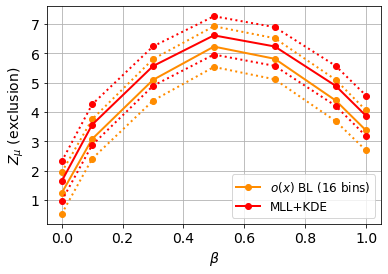

In [37]:
plt.figure()
lw = 2

plt.plot(beta, results_16bins_beta, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)')
plt.plot(beta, results_16bins_beta_plus, ':o', color='darkorange', lw=lw) 
plt.plot(beta, results_16bins_beta_min, ':o', color='darkorange', lw=lw) 

# plt.plot(beta, results_50bins_beta, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)')
# plt.plot(beta, results_50bins_beta_plus, ':o', color='blue', lw=lw) 
# plt.plot(beta, results_50bins_beta_min, ':o', color='blue', lw=lw) 

# plt.plot(beta, results_100bins_beta, '-o', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)')
# plt.plot(beta, results_100bins_beta_plus, ':o', color='dodgerblue', lw=lw) 
# plt.plot(beta, results_100bins_beta_min, ':o', color='dodgerblue', lw=lw) 

plt.plot(beta, results_MLL_KDE_beta, '-o', color='red', lw=lw, label=r'MLL+KDE')
plt.plot(beta, results_MLL_KDE_beta_plus, ':o', color='red', lw=lw) 
plt.plot(beta, results_MLL_KDE_beta_min, ':o', color='red', lw=lw) 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
#plt.xscale('log')
plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(fontsize=12)
plt.show()